## DATASET LINK
Link: https://drive.google.com/drive/folders/1tX3uTlIGFQHDUel0ftASEqMBXfeKIEko?usp=drive_link

In [1]:
# dataset /images and /labels folder
# label using json
#json contains:
#img_id
#human_num: num of head
#points: x y coordinate for the head point

In [2]:

import os
import json
import glob
import random
import shutil
import time
import math


import numpy as np
import h5py
import scipy.io as io
from scipy.ndimage import gaussian_filter
from PIL import Image, ImageDraw, ImageFont
import cv2
import matplotlib.pyplot as plt
from matplotlib import cm as CM
from tqdm import tqdm


# PyTorch & torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import interpolate
from torch.utils.data import Dataset, DataLoader
from torchvision import models, datasets, transforms
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode


# Scikit-learn

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error



In [2]:


def set_seed(seed=42):
    random.seed(seed)                 # Python random
    np.random.seed(seed)              # Numpy
    torch.manual_seed(seed)           # CPU
    torch.cuda.manual_seed(seed)      # GPU current
    torch.cuda.manual_seed_all(seed)  # Multi-GPU

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(42)


In [3]:
pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.7 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: n

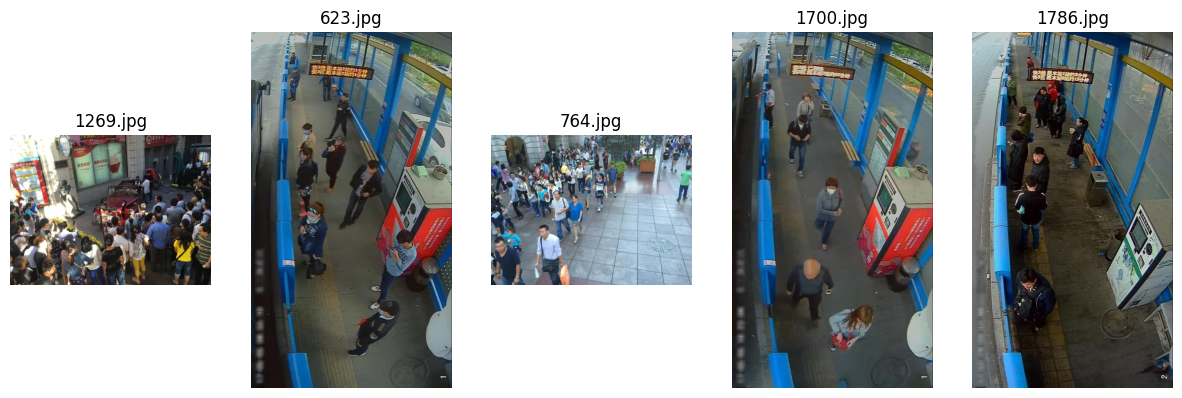

In [4]:


img_folder = "/kaggle/input/dataset-besar/dataset_besar-20250923T053208Z-1-001/dataset_besar/train/images/"

# first 5 images
img_files = [f for f in os.listdir(img_folder) if f.lower().endswith(('.jpg','.png'))][:5]


plt.figure(figsize=(15,8))
for i, img_file in enumerate(img_files):
    img_path = os.path.join(img_folder, img_file)
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1,5,i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{img_file}")
plt.show()



## Split dataset into train / validation / test folders

This cell performs the following tasks:
1. Define target folders in Kaggle Working directory for train, val, and test images and labels.
2. Create the folders if they do not exist.
3. List all images from the source dataset folder.
4. Split the images into train (80%), validation (10%), and test (10%).
5. Copy images and their corresponding JSON label files into the target folders.
6. Save the filenames for each split into separate JSON files (train_imgs.json, val_imgs.json, test_imgs.json).

This ensures that all data is organized and ready for downstream training and evaluation.


In [5]:


saving_path = "/kaggle/working/split_data"

# Folder source dataset (read-only)
images_path = "/kaggle/input/dataset-besar/dataset_besar-20250923T053208Z-1-001/dataset_besar/train/images"
labels_path = "/kaggle/input/dataset-besar/dataset_besar-20250923T053208Z-1-001/dataset_besar/train/labels"

# Folder target
train_img_dir = os.path.join(saving_path, "train", "images")
train_label_dir = os.path.join(saving_path, "train", "labels")
val_img_dir   = os.path.join(saving_path, "val", "images")
val_label_dir = os.path.join(saving_path, "val", "labels")
test_img_dir  = os.path.join(saving_path, "test", "images")
test_label_dir= os.path.join(saving_path, "test", "labels")


for d in [train_img_dir, train_label_dir, val_img_dir, val_label_dir, test_img_dir, test_label_dir]:
    os.makedirs(d, exist_ok=True)


all_images = sorted([f for f in os.listdir(images_path) if f.lower().endswith((".jpg", ".png"))])


# Split train / val / test
train_val_imgs, test_imgs = train_test_split(all_images, test_size=0.1, random_state=42)
train_imgs, val_imgs = train_test_split(train_val_imgs, test_size=0.1/0.9, random_state=42)




# Fungsi copy file
def copy_files(img_list, src_img, src_label, dst_img, dst_label):
    for img_file in img_list:
        label_file = img_file.rsplit('.',1)[0] + ".json"  
        shutil.copy(os.path.join(src_img, img_file), os.path.join(dst_img, img_file))
        shutil.copy(os.path.join(src_label, label_file), os.path.join(dst_label, label_file))


# Copy to target folder 
copy_files(train_imgs, images_path, labels_path, train_img_dir, train_label_dir)
copy_files(val_imgs, images_path, labels_path, val_img_dir, val_label_dir)
copy_files(test_imgs, images_path, labels_path, test_img_dir, test_label_dir)

print(f"Train images: {len(train_imgs)}, Val images: {len(val_imgs)}, Test images: {len(test_imgs)}")

#save to json
for split_name, split_list in zip(["train","val","test"], [train_imgs, val_imgs, test_imgs]):
    with open(os.path.join(saving_path, f"{split_name}_imgs.json"), 'w') as f:
        json.dump(split_list, f)

print("JSON files for train/val/test successfully created!")
print(f"All split data saved under: {saving_path}")


Train images: 1520, Val images: 190, Test images: 190
JSON files for train/val/test successfully created!
All split data saved under: /kaggle/working/split_data


Images with <200 heads: 1219
Images with 200-500 heads: 205
Images with >500 heads: 96

--- Low Crowd (<200 heads) (showing 3 examples) ---


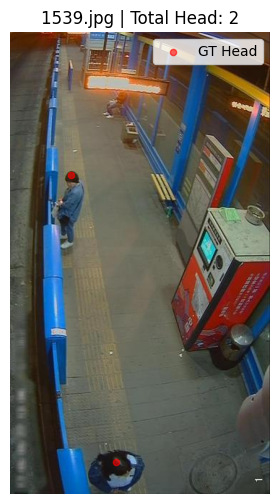

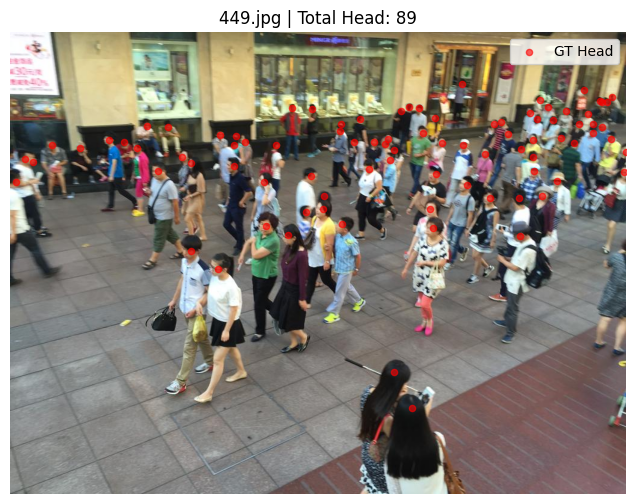

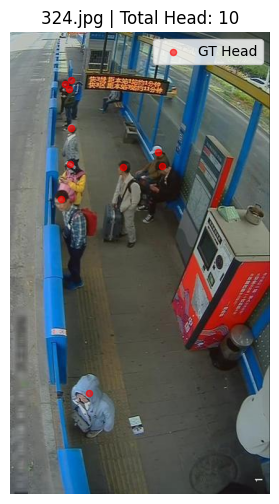


--- Medium Crowd (200-500 heads) (showing 3 examples) ---


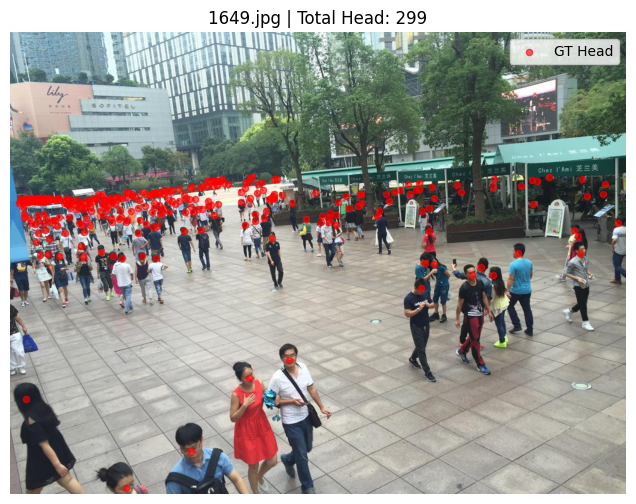

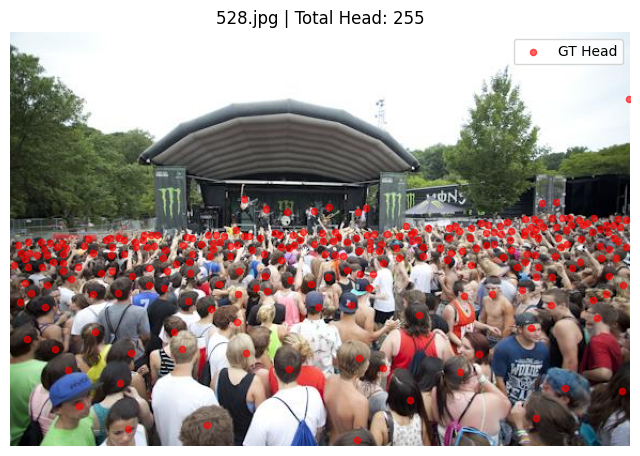

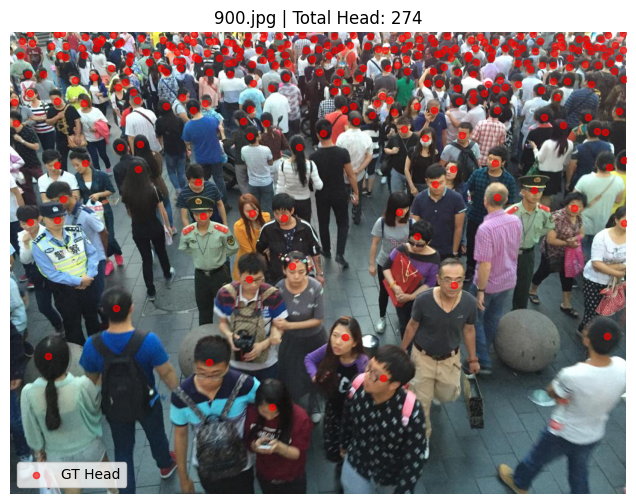


--- High Crowd (>500 heads) (showing 3 examples) ---


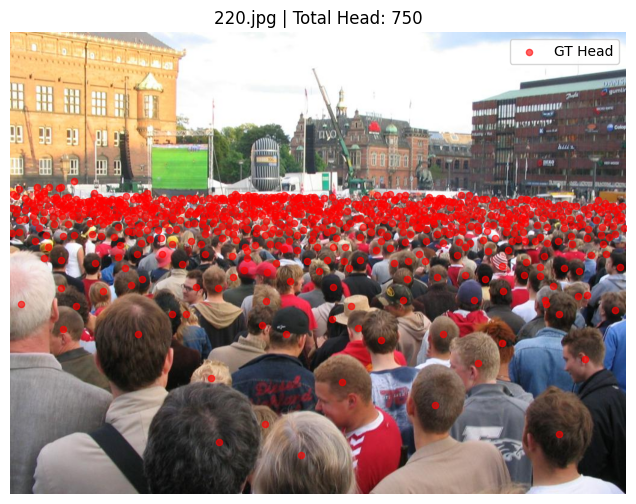

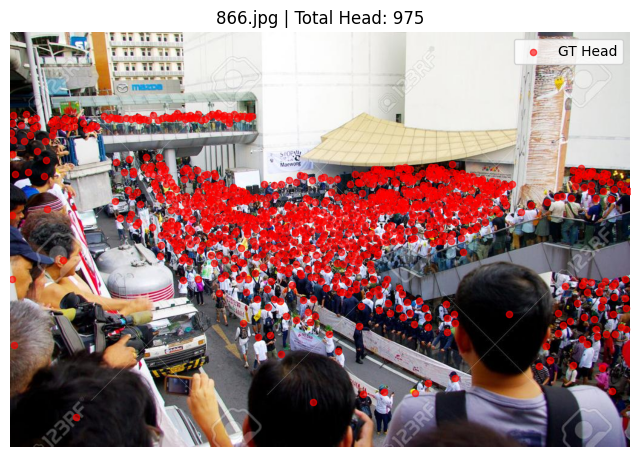

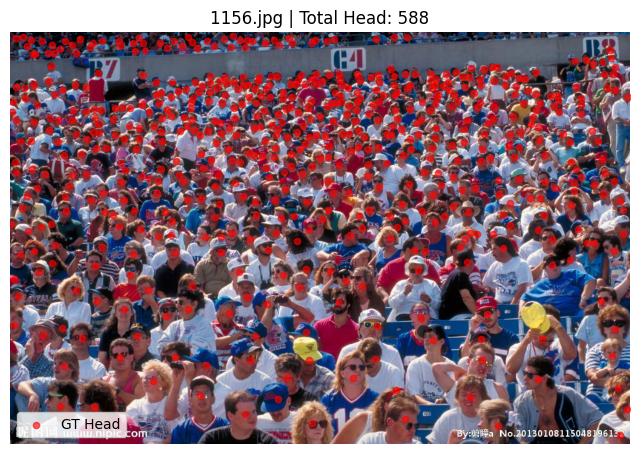

In [6]:



saving_path = "/kaggle/working/split_data"
train_img_dir = os.path.join(saving_path, "train", "images")
train_label_dir = os.path.join(saving_path, "train", "labels")


with open(os.path.join(saving_path, "train_imgs.json"), 'r') as f:
    train_imgs = json.load(f)

# Categories
cat_low = []      # <200 heads
cat_medium = []   # 200-500 heads
cat_high = []     # >500 heads

# Categorize images
for img_file in train_imgs:
    label_file = os.path.join(train_label_dir, img_file.rsplit('.',1)[0]+".json")
    with open(label_file, 'r') as lf:
        gt = json.load(lf)
    human_num = gt['human_num']
    
    if human_num < 200:
        cat_low.append(img_file)
    elif 200 <= human_num <= 500:
        cat_medium.append(img_file)
    else:
        cat_high.append(img_file)


print(f"Images with <200 heads: {len(cat_low)}")
print(f"Images with 200-500 heads: {len(cat_medium)}")
print(f"Images with >500 heads: {len(cat_high)}")


def show_examples(img_list, category_name, n=3):
    print(f"\n--- {category_name} (showing {n} examples) ---")
    for img_file in img_list[:n]:
        img_path = os.path.join(train_img_dir, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        label_file = os.path.join(train_label_dir, img_file.rsplit('.',1)[0]+".json")
        with open(label_file, 'r') as lf:
            gt = json.load(lf)
        
        # Clamp points inside image
        xs = [min(max(0, p['x']), img.shape[1]-1) for p in gt['points']]
        ys = [min(max(0, p['y']), img.shape[0]-1) for p in gt['points']]
        human_num = gt['human_num']


        plt.figure(figsize=(8,6))
        plt.imshow(img)
        plt.title(f"{img_file} | Total Head: {human_num}")
        plt.scatter(xs, ys, c='red', s=20, alpha=0.6, label='GT Head')
        plt.axis('off')
        plt.legend()
        plt.show()


show_examples(cat_low, "Low Crowd (<200 heads)")
show_examples(cat_medium, "Medium Crowd (200-500 heads)")
show_examples(cat_high, "High Crowd (>500 heads)")



## Convert JSON annotations to H5 density maps

This cell processes all training and validation images to generate 
corresponding density maps and save them as H5 files. 
Steps:
1. Load each image and its JSON label file containing crowd points.
2. Create an empty density map of the same size as the image.
3. Mark each annotated point in the density map with 1.
4. Apply Gaussian filter (sigma=15) to spread each point into a smooth density blob.
5. Save the resulting density map into a .h5 file in the corresponding folder.

These H5 files will be later used by the CrowdPatchDataset for patch-based training.


In [7]:


# Path folder image 
train_img_dir = "/kaggle/working/split_data/train/images/"
val_img_dir   = "/kaggle/working/split_data/val/images/"


train_h5_dir = "/kaggle/working/split_data/train/h5_data/"
val_h5_dir   = "/kaggle/working/split_data/val/h5_data/"
os.makedirs(train_h5_dir, exist_ok=True)
os.makedirs(val_h5_dir, exist_ok=True)


img_paths = glob.glob(os.path.join(train_img_dir, "*.jpg")) + \
            glob.glob(os.path.join(val_img_dir, "*.jpg"))

for img_path in tqdm(img_paths):
    filename = os.path.basename(img_path)


    if "train" in img_path:
        saving_path_file = os.path.join(train_h5_dir, filename.replace(".jpg", ".h5"))
    else:
        saving_path_file = os.path.join(val_h5_dir, filename.replace(".jpg", ".h5"))

    if os.path.exists(saving_path_file):
        continue

    # 1. Load image 
    img = np.array(Image.open(img_path).convert("RGB"))
    H, W = img.shape[:2]

    # 2. Load JSON label 
    label_path = img_path.replace("/images/", "/labels/").replace(".jpg", ".json")
    with open(label_path, "r") as f:
        ann = json.load(f)
    gt_points = ann["points"]

    # 3. make ground truth density map 
    k = np.zeros((H, W), dtype=np.float32)
    for p in gt_points:
        x, y = int(p["x"]), int(p["y"])
        if 0 <= x < W and 0 <= y < H:
            k[y, x] = 1

    k = gaussian_filter(k, sigma=15)


    with h5py.File(saving_path_file, 'w') as hf:
        hf['density'] = k

print("Density maps saved to train/val h5_data folders")


100%|██████████| 1710/1710 [02:04<00:00, 13.70it/s]

Density maps saved to train/val h5_data folders


## CrowdPatchDataset — Patch-based Dataset with Augmentation

### Overview

`CrowdPatchDataset` is a custom PyTorch dataset for crowd counting.  
It is designed to:

1. Split each image into multiple patches (perfect square number)
2. Load corresponding precomputed density maps from H5 files
3. Apply safe data augmentations(augmentation that doesnt break the GT of density map)
4. Return patch and its density map ready for model training

This patch-based approach improves learning on high-resolution images while keeping memory usage manageable.

---

### Features

**Patch Splitting**  
- `num_patches` must be a perfect square (e.g., 4, 9, 16)  
- Each image is divided into `grid x grid` patches  
- Both image and density map are cropped synchronously  

**Density Map Handling**  
- Density maps are stored in H5 files  
- Interpolated to match CSRNet output size (1/8 of image resolution)  
- Rescaled to maintain correct total count

**Augmentation**  
- Safe augmentations applied only when appropriate:
  - Horizontal flip (with duplication probability based on crowd size)
  - Random rotation ±`rotate_degree`
  - Color jitter (brightness, contrast, saturation)
- Augmentations ensure the density sum is preserved

**Patch Synchronization**  
- Each image patch is paired with the corresponding cropped density map  
- Ensures model sees correct local crowd distribution

---

### Why This Dataset is Important

- Splitting images into patches for more data samples
- Focuses the model on smaller regions, improving local crowd density prediction  
- Augmentation increases diversity of training samples, reducing overfitting  
- Duplication strategy balances underrepresented medium-density patches




In [3]:

class CrowdPatchDataset(Dataset):
    def __init__(self, img_dir, img_list, num_patches=4,
                 dup_probabilities=(0.3, 0.5, 0.9),
                 rotate_degree=15):
        """
        img_dir: folder image
        img_list: list of image filenames
        num_patches: number of patches per image (must perfect square)
        dup_probabilities: duplication probabilities for different headcount ranges
        rotate_degree: max rotation ±degree
        """
        self.img_dir = img_dir
        self.img_list = img_list
        self.num_patches = num_patches
        self.grid = int(np.sqrt(num_patches))
        assert self.grid * self.grid == num_patches, "num_patches must be perfect square (4, 9, 16, ...)"
        self.resize_img_to = (256, 256)  # ukuran CSRNet
        self.dup_prob_10_20 = dup_probabilities[0]
        self.dup_prob_20_50 = dup_probabilities[1]
        self.dup_prob_50_plus = dup_probabilities[2]
        self.rotate_degree = rotate_degree

        print(f" Loaded {len(self.img_list)} images, Patch per image = {self.num_patches}")

    def __len__(self):
        return len(self.img_list) * self.num_patches

    def __getitem__(self, idx):
        img_idx = idx // self.num_patches
        patch_idx = idx % self.num_patches

        img_name = self.img_list[img_idx]
        img_path = os.path.join(self.img_dir, img_name)
        h5_path = img_path.replace("/images/", "/h5_data/").replace(".jpg", ".h5")

        
        # Load & resize full image
        img = Image.open(img_path).convert("RGB")
        img = img.resize(self.resize_img_to)

        # load density map
        with h5py.File(h5_path, 'r') as hf:
            density = np.array(hf['density'], dtype=np.float32)
        density = torch.tensor(density, dtype=torch.float32)

        H, W = density.shape
        new_H = self.resize_img_to[0] // 8
        new_W = self.resize_img_to[1] // 8

        density = density.unsqueeze(0).unsqueeze(0)
        density = torch.nn.functional.interpolate(
            density, size=(new_H, new_W), mode="bilinear", align_corners=False
        )
        scale = (H * W) / (new_H * new_W)
        density = density * scale
        density = density.squeeze(0).squeeze(0)

        
        # Crop patch (make sure syncronize image + density)
        patch_w = self.resize_img_to[0] // self.grid
        patch_h = self.resize_img_to[1] // self.grid
        den_patch_w = new_H // self.grid
        den_patch_h = new_W // self.grid

        gx = patch_idx % self.grid
        gy = patch_idx // self.grid

        x1 = gx * patch_w
        y1 = gy * patch_h
        x2 = x1 + patch_w
        y2 = y1 + patch_h

        img_patch = img.crop((x1, y1, x2, y2))
        density = density[
            gy * den_patch_h:(gy + 1) * den_patch_h,
            gx * den_patch_w:(gx + 1) * den_patch_w
        ]


        # Augmentation
        people_count = density.sum().item()

        # Duplication + horizontal flip
        if 10 <= people_count <= 20:
            do_dup = random.random() < self.dup_prob_10_20
        elif 20 < people_count <= 50:
            do_dup = random.random() < self.dup_prob_20_50
        elif people_count > 50:
            do_dup = random.random() < self.dup_prob_50_plus
        else:
            do_dup = False

        if do_dup and random.random() < 0.9:
            img_patch = TF.hflip(img_patch)
            density = TF.hflip(density)

        # Random rotation ±rotate_degree (convert density to PIL)
        angle = random.uniform(-self.rotate_degree, self.rotate_degree)
        img_patch = TF.rotate(img_patch, angle, interpolation=TF.InterpolationMode.BILINEAR)
        density_img = TF.to_pil_image(density.unsqueeze(0))        # [1,H,W] -> PIL
        density_img = TF.rotate(density_img, angle, interpolation=TF.InterpolationMode.BILINEAR)
        density = TF.to_tensor(density_img).squeeze(0)            # kembali ke tensor

        # Color jitter (brightness/contrast/saturation)
        color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)
        img_patch = color_jitter(img_patch)


        # Final transform image
        img_patch = TF.to_tensor(img_patch)
        img_patch = TF.normalize(img_patch,
                                 mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

        return img_patch, density.unsqueeze(0)


## Dataloader | Viusalize | Check Distribution

In [4]:

SPLIT_PATH = "/kaggle/working/split_data"

with open(os.path.join(SPLIT_PATH, "train_imgs.json"), 'r') as f:
    train_list = json.load(f)

with open(os.path.join(SPLIT_PATH, "val_imgs.json"), 'r') as f:
    val_list = json.load(f)




In [5]:

# Duplication probabilities for data augmentation based on crowd size:
#   - 0.3 for patches with 10–20 people
#   - 0.5 for patches with 21–50 people
#   - 0.9 for patches with more than 50 people
# This helps balance the dataset by duplicating medium/high-density patches more often.

train_dataset = CrowdPatchDataset(
    img_dir="/kaggle/working/split_data/train/images",
    img_list=train_list,
    num_patches=9, #if num_patch=4, then 1 image is divided to 4 patch
    dup_probabilities=(0.3, 0.5, 0.9),
)

val_dataset = CrowdPatchDataset(
    img_dir="/kaggle/working/split_data/val/images",
    img_list=val_list,
    num_patches=9,
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Dataloader OK")


 Loaded 1520 images, Patch per image = 9
 Loaded 190 images, Patch per image = 9
Dataloader OK


In [11]:


ranges = {
    "< 1": 0,
    "1–10": 0,
    "10–20": 0,
    "20–30": 0,
    "30–40": 0,
    "40–50": 0,
    "50–100": 0,
    "100–200": 0,
    "200+": 0
}

total_patches = 0

for imgs, densities in train_loader:
    # densities shape: [B, 1, H, W]
    counts = densities.sum(dim=(1, 2, 3)).cpu().numpy()

    for c in counts:
        total_patches += 1
        if c < 1:
            ranges["< 1"] += 1
        elif c < 10:
            ranges["1–10"] += 1
        elif c < 20:
            ranges["10–20"] += 1
        elif c < 30:
            ranges["20–30"] += 1
        elif c < 40:
            ranges["30–40"] += 1
        elif c < 50:
            ranges["40–50"] += 1
        elif c < 100:
            ranges["50–100"] += 1
        elif c < 200:
            ranges["100–200"] += 1
        else:
            ranges["200+"] += 1

print("\n Headcount Distribution on Train Loader:")
for k, v in ranges.items():
    print(f"{k} : {v} patches")

print(f"\nTotal patches analyzed: {total_patches}")



 Headcount Distribution on Train Loader:
< 1 : 6061 patches
1–10 : 4762 patches
10–20 : 1081 patches
20–30 : 736 patches
30–40 : 493 patches
40–50 : 381 patches
50–100 : 166 patches
100–200 : 0 patches
200+ : 0 patches

Total patches analyzed: 13680


In [12]:
sample_img, sample_density = next(iter(train_loader))
print("Images:", sample_img.shape)
print("Density:", sample_density.shape)


Images: torch.Size([32, 3, 85, 85])
Density: torch.Size([32, 1, 10, 10])



 Crowd Patch Statistics:
Total patches (after duplication): 13680
Mean count per patch   : 6.95
Median count per patch : 1.45
Min count patch        : 0.00
Max count patch        : 71.87
Std deviation          : 12.02


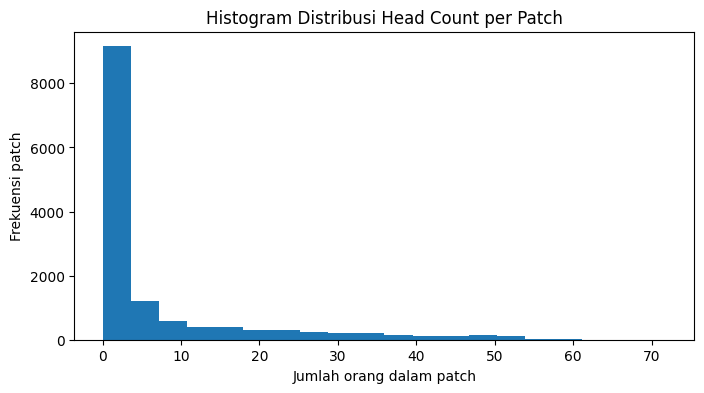

In [13]:


# calculate head count from dataset
patch_counts = []

print("Collecting patch statistics (sampling dataset)...")

for i in range(len(train_dataset)):
    _, density = train_dataset[i]  
    people_count = torch.sum(density).item()
    patch_counts.append(people_count)

patch_counts = np.array(patch_counts)


print("\n Crowd Patch Statistics:")
print(f"Total patches (after duplication): {len(patch_counts)}")
print(f"Mean count per patch   : {patch_counts.mean():.2f}")
print(f"Median count per patch : {np.median(patch_counts):.2f}")
print(f"Min count patch        : {patch_counts.min():.2f}")
print(f"Max count patch        : {patch_counts.max():.2f}")
print(f"Std deviation          : {patch_counts.std():.2f}")


plt.figure(figsize=(8,4))
plt.hist(patch_counts, bins=20)
plt.title("Histogram Distribusi Head Count per Patch")
plt.xlabel("Jumlah orang dalam patch")
plt.ylabel("Frekuensi patch")
plt.show()


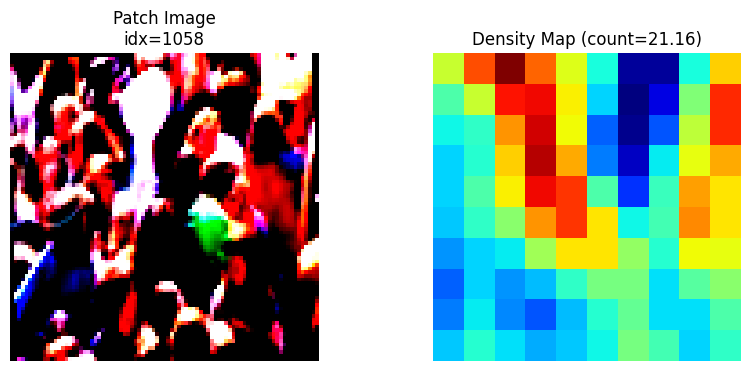

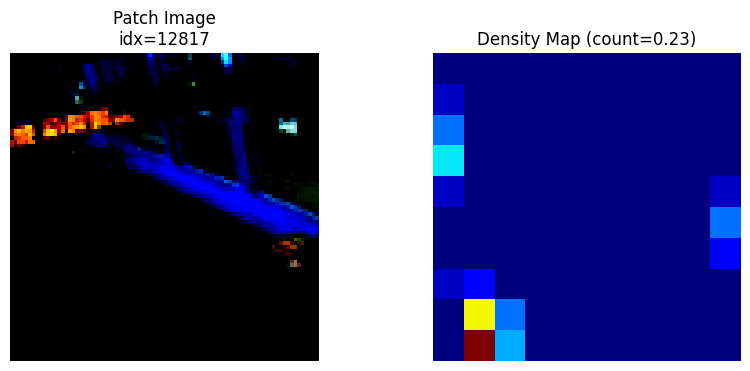

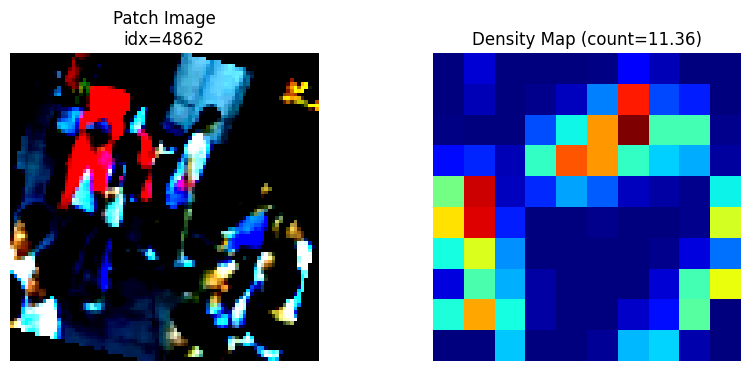

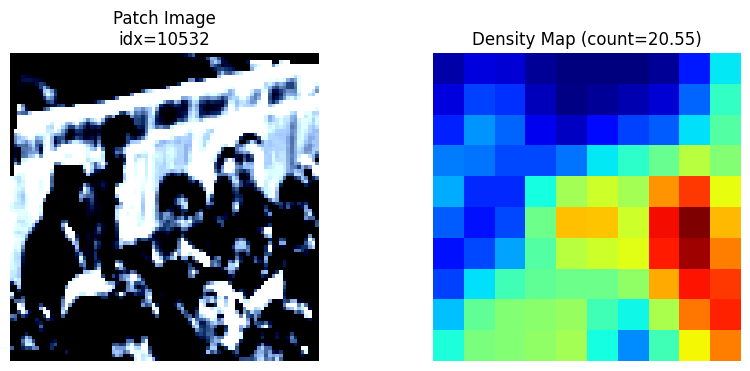

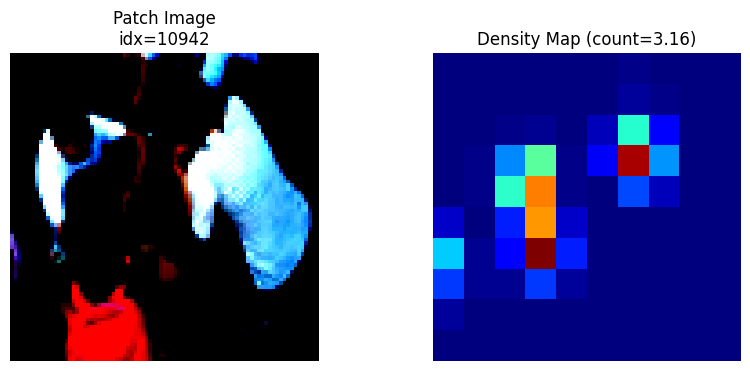

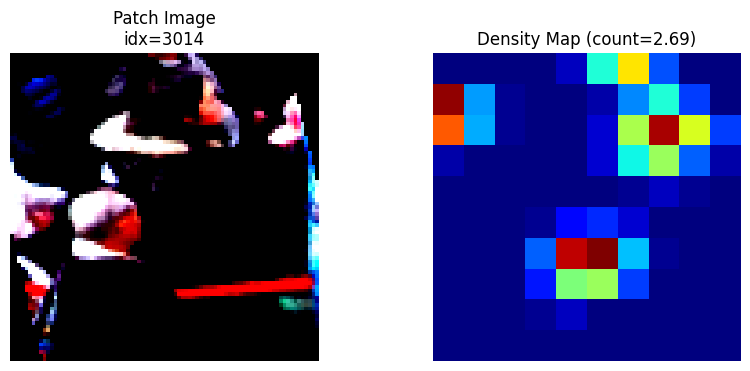

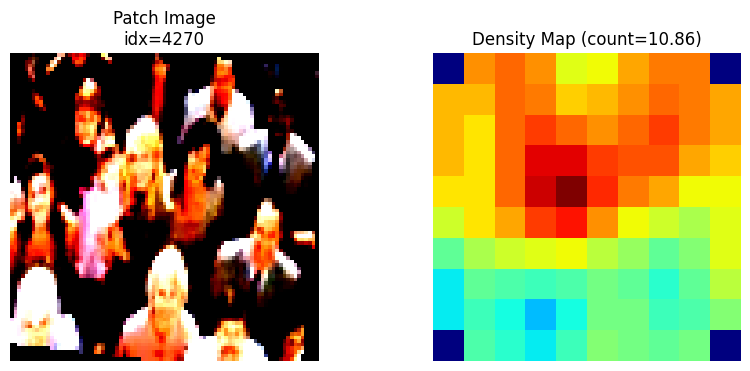

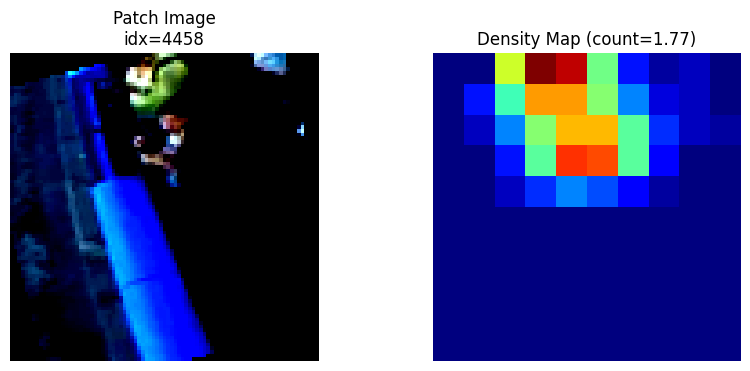

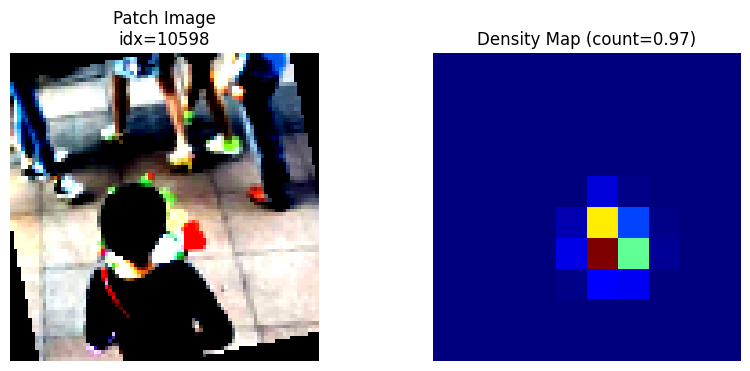

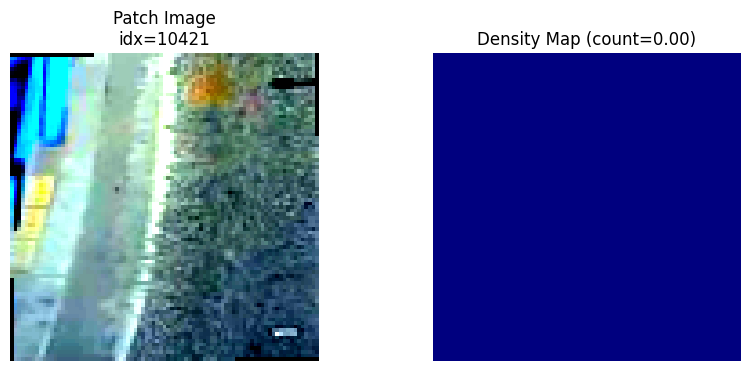

In [14]:

def visualize_random_patch(dataset, num_samples=3):

    indices = random.sample(range(len(dataset)), num_samples)

    for idx in indices:
        img_tensor, density_tensor = dataset[idx]

        img = img_tensor.permute(1, 2, 0).numpy()
        density = density_tensor.squeeze(0).numpy()

        fig, ax = plt.subplots(1, 2, figsize=(10, 4))

        ax[0].imshow(img)
        ax[0].set_title(f"Patch Image\nidx={idx}")
        ax[0].axis("off")

        ax[1].imshow(density, cmap="jet")
        ax[1].set_title(f"Density Map (count={density.sum():.2f})")
        ax[1].axis("off")

        plt.show()


visualize_random_patch(train_dataset, num_samples=12)


## Visualizing Patches on Original Image

This function shows the original image overlaid with a grid of patches.  
For each patch:

- Draws a red rectangle to indicate patch boundaries  
- Computes and displays the **people count** within that patch from the density map
  
This helps visually understand how the model splits the image into patches and distributes the predicted counts.  
Useful for inspecting density map patching behavior and checking if sparse or dense regions are captured correctly.


In [15]:
def show_patches_on_original(dataset, idx):



    img_name = dataset.img_list[idx]
    img_path = os.path.join(dataset.img_dir, img_name)
    h5_path = img_path.replace("/images/", "/h5_data/").replace(".jpg", ".h5")

    # Load full image
    img = Image.open(img_path).convert("RGB")
    W, H = img.size

    # Load density
    with h5py.File(h5_path, 'r') as hf:
        density = np.array(hf["density"])  # (H_orig, W_orig)

    density = torch.tensor(density, dtype=torch.float32)
    H_orig, W_orig = density.shape
    new_H = dataset.resize_img_to[0] // 8
    new_W = dataset.resize_img_to[1] // 8

    # Resize density sum-preserving
    density = density.unsqueeze(0).unsqueeze(0)
    density = torch.nn.functional.interpolate(
        density, size=(new_H, new_W), mode="bilinear", align_corners=False
    ).squeeze(0).squeeze(0)
    density = density * (H_orig * W_orig) / (new_H * new_W)
    density_np = density.numpy()

    # Patch grid
    grid = dataset.grid
    patch_W = W // grid
    patch_H = H // grid
    den_patch_W = new_W // grid
    den_patch_H = new_H // grid

    draw = ImageDraw.Draw(img)
    try:
        font = ImageFont.truetype("DejaVuSans-Bold.ttf", 18)
    except:
        font = None

    # Loop  patch
    for gy in range(grid):
        for gx in range(grid):
            x1 = gx * patch_W
            y1 = gy * patch_H
            x2 = x1 + patch_W
            y2 = y1 + patch_H


            d_x1 = gx * den_patch_W
            d_x2 = (gx + 1) * den_patch_W
            d_y1 = gy * den_patch_H
            d_y2 = (gy + 1) * den_patch_H

            patch_count = np.sum(density_np[d_y1:d_y2, d_x1:d_x2])

            # Draw rectangle + count
            draw.rectangle([x1, y1, x2, y2], outline="red", width=3)
            draw.text((x1 + 5, y1 + 5), f"{patch_count:.1f}", fill="yellow", font=font)


    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(f"{img_name} — {dataset.num_patches} patches")
    plt.axis("off")
    plt.show()


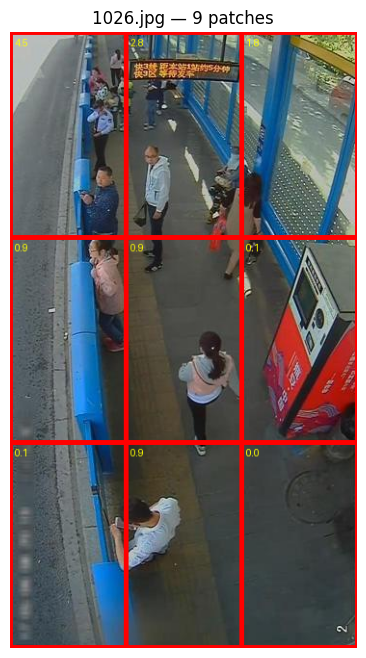

In [16]:
show_patches_on_original(train_dataset, idx=random.randint(2, len(train_dataset.img_list)-1))


In [17]:

# Install segmentation-models-pytorch 
!pip install segmentation-models-pytorch --quiet


## Model 1 — CSRNet-Tiny (Lightweight Scratch Model)

### Overview

`CSRNet-Tiny` is a very lightweight crowd-counting model inspired by CSRNet, but built without using any pretrained backbone.  
It keeps the essential structure:

1. A VGG-like frontend (Conv → ReLU → MaxPool) for feature extraction
2. A dilated convolution backend to enlarge the receptive field
3. A 1-channel output layer that produces a density map

The model is intentionally minimal to serve as a baseline against the pretrained `CSRNet-Lite`.

---

### Architecture Breakdown

**Frontend (Encoder)**  
- Stack of convolution layers similar to VGG but much smaller  
- MaxPooling progressively reduces spatial size from full resolution to 1/8
- Responsible for learning lower-level visual features (edges, textures)

**Backend (Dilated Convolution)**  
- Uses dilated convolution layers with dilation rate = 2  
- Allows the model to “see” a wider context without reducing resolution
- Important for crowd counting because density maps require spatial detail

**Output Layer**  
- A 1x1 convolution that converts the final feature map into a density map  
- Output is 1 channel: each pixel represents crowd density

---

### Why CSRNet-Tiny Underperforms Compared to CSRNet-Lite

CSRNet-Tiny learns **everything from scratch**.

It does not start with any pretrained knowledge.  
This means:
- The model must learn edges, corners, textures, and crowd patterns entirely from the dataset.
- Training takes longer and converges slower.
- It is more likely to produce false positives, especially on sparse or empty scenes.

Meanwhile, `CSRNet-Lite` uses a pretrained VGG16 backbone.  
That model already knows how to detect shapes and textures from millions of images.  
So instead of first learning *how to see*, it focuses directly on *how to count*.

In validation results, CSRNet-Tiny often predicts small density values even in empty patches.  
This happens because it is not confident enough to distinguish background vs. crowd textures.

---

### Observed Result

On the full test set (190 images):

- CSRNet-Tiny achieved MAE = **46.75**
- It struggles primarily on sparse crowds or empty images
- It tends to "hallucinate" that there are people when there are none

These behaviors come from the weak low-level feature extractor caused by training from scratch.

---

### Conclusion

CSRNet-Tiny is useful as a baseline because it proves a key finding:

> Dilated convolution alone is not enough. Crowd counting requires strong feature extraction.

The pretrained backbone in `CSRNet-Lite` dramatically improves performance because:

- It already understands basic visual features
- It converges faster
- It generalizes better across different densities

Thus, CSRNet-Lite is chosen as the final model.  
CSRNet-Tiny shows the gap that transfer learning closes.



In [18]:


class CRSNetTiny(nn.Module):
    def __init__(self):
        super(CRSNetTiny, self).__init__()

        # Frontend Encoder (VGG-like Tiny)
        self.frontend = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(True),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(True),
            nn.MaxPool2d(2),  # 1/2

            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(True),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(True),
            nn.MaxPool2d(2),  # 1/4

            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(True),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(True),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(True),
            nn.MaxPool2d(2),  # 1/8

            nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(True),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(True),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(True),
        )

        # Backend dilated conv 
        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=2, dilation=2), nn.ReLU(True),
            nn.Conv2d(512, 256, 3, padding=2, dilation=2), nn.ReLU(True),
            nn.Conv2d(256, 128, 3, padding=2, dilation=2), nn.ReLU(True),
            nn.Conv2d(128, 64, 3, padding=2, dilation=2), nn.ReLU(True),
            nn.Conv2d(64, 32, 3, padding=2, dilation=2), nn.ReLU(True),
        )

        # Output layer 
        self.output_layer = nn.Sequential(
            nn.Conv2d(32, 1, 1)
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return torch.abs(x)  # ensure non-negative density

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

device = "cuda" if torch.cuda.is_available() else "cpu"
# Create model
model = CRSNetTiny().to(device)
print("CSRNet-Tiny Loaded ✅")

# Test Set Evaluated: 190 images
# Mean Absolute Error (MAE) on Test Set = 46.75
# epoch 3 batchsize = 32
# comment = The model struggles when the crowd is sparse. In the validation set, it can be seen that the model still predicts a small number of people even in empty patches.


CSRNet-Tiny Loaded ✅


## Model 2 Architecture — CSRNetLite (VGG16 + Dilated Convolution)

CSRNetLite is a model designed for **crowd counting / density map estimation**.  
Instead of predicting a single count number, the model generates a **density map**, and the total count is obtained by summing the pixel values of that map.

---

### Architecture Overview

CSRNetLite consists of three main parts:

1. **Frontend (Feature Extractor — pretrained VGG16)**  
   Uses VGG16 up to `conv4_3` (no fully connected layers).  
   - Preserves spatial resolution (important for localization).
   - Benefits from transfer learning (faster convergence and better accuracy).

2. **Backend (Dilated Convolution Blocks — lightweight CSRNet)**  
   Dilated convolution increases the *receptive field* without pooling, allowing the model to “see wider” while keeping details intact.

3. **Output Layer (1-channel density map)**  
   Produces a single channel output with spatial resolution `(H/8 × W/8)`.

---

### Why Dilated Convolution?

> Dilated convolution = regular convolution but with spacing between sampled pixels.

Benefits:
1. Larger receptive field  
2. No extra parameters  
3. No downsampling (keeps small-object detail)


---

### Why VGG16 (pretrained)?

- Early CNN layers already learned **edges, textures, and small patterns**.
- Stable performance on datasets with limited size.
- Suited for pixel-wise tasks (segmentation, density estimation).

---

### Why is this architecture effective for density maps?


1. VGG16 pretrained -> Extracts strong visual features -> small objects remain detectable 
2. Dilated convolution blocks -> Enlarges receptive field without pooling -> model understands *where* objects are |
3. 1-channel conv output -> Generates density map -> counts = sum of pixel values |







In [6]:

class CSRNetLite(nn.Module):
    def __init__(self):
        super(CSRNetLite, self).__init__()

        # Backbone (VGG16 pretrained, feature extractor)
        backbone = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        features = list(backbone.features.children())

        #  only to layer conv4_3 (without fully connected)
        self.frontend = nn.Sequential(*features[:23])  # (conv1 -> conv4)

        # Backend (Dilated Convolution Blocks — lighter than CSRNet)
        self.backend = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 128, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 64, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        # Output density map (1 channel)
        self.output_layer = nn.Conv2d(32, 1, kernel_size=1)
        self._init_weights()

    def _init_weights(self):
  
        for m in self.backend.children():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

        nn.init.normal_(self.output_layer.weight, std=0.01)
        nn.init.constant_(self.output_layer.bias, 0)

    def forward(self, x):
        x = self.frontend(x)     # -> pretrained feature extractor
        x = self.backend(x)      # -> dilated conv for density
        x = self.output_layer(x) # -> 1 channel density map

        # output shape: (B, 1, H/8, W/8)
        return x
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CSRNetLite().to(device)

#Test Set Evaluated: 190 images
#Mean Absolute Error (MAE) on Test Set = 32.90


### Validation Visualization (Random Samples)

This function visualizes model predictions during training.
It randomly selects samples from the validation DataLoader,
then displays:
- Original image
- Ground-truth density map (GT)
- Predicted density map (model output)



In [7]:


def visualize_prediction(model, val_loader, device, num_samples=3):

    model.eval()

    # take all data batch then to list
    all_imgs = []
    all_targets = []
    for imgs, targets in val_loader:
        all_imgs.append(imgs)
        all_targets.append(targets)
    all_imgs = torch.cat(all_imgs, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # random sample
    indices = random.sample(range(all_imgs.shape[0]), min(num_samples, all_imgs.shape[0]))

    with torch.no_grad():
        imgs_batch = all_imgs[indices].to(device)
        targets_batch = all_targets[indices].to(device)
        preds = model(imgs_batch)

    for i, idx in enumerate(indices):
        img = imgs_batch[i].cpu().permute(1, 2, 0).numpy()
        gt = targets_batch[i].cpu().squeeze().numpy()
        pred = preds[i].cpu().squeeze().numpy()

        gt_count = gt.sum()
        pred_count = pred.sum()

        plt.figure(figsize=(12,4))
        
        plt.subplot(1,3,1)
        plt.imshow(img)
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1,3,2)
        plt.imshow(gt, cmap="jet")
        plt.title(f"GT Count = {gt_count:.2f}")
        plt.axis("off")

        plt.subplot(1,3,3)
        plt.imshow(pred, cmap="jet")
        plt.title(f"Predicted Count = {pred_count:.2f}")
        plt.axis("off")

        plt.show()



## Model Training + Validation + Checkpointing

This block contains the full training pipeline for CSRNet-Lite:

### Hyperparameters
- learning rate
- weight decay (regularization)
- early stopping patience
- num of epochs

### Loss Function + Optimizer + LR Scheduler
- MSELoss is used because density maps are regression outputs.
- Adam optimizer gives faster convergence on noisy gradients.
- ReduceLROnPlateau lowers LR when validation loss plateaus.

## train_epoch()
- Runs a full epoch: forward -> loss -> backward -> optimizer step.
- Tracks running loss and prints progress every `print_freq` batches.

### validate_epoch()
- Evaluates the model without gradient updates.
- Computes:
  • Validation loss (MSE on density map)
  • MAE (error in total people count)
  • RMSE (penalizes larger errors)

### save_checkpoint()
- Saves current weights, and if it's the best model so far,
- also updates `model_best.pth.tar`.

### Training Loop
- Trains for N epochs
- Evaluates after each epoch
- Visualizes predictions along the way
- Early stopping if no improvement after 'patience' epochs




/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[Epoch 0] Step 64/428, Loss: 61.2752
[Epoch 0] Step 128/428, Loss: 20.6543
[Epoch 0] Step 192/428, Loss: 36.3237
[Epoch 0] Step 256/428, Loss: 41.0651
[Epoch 0] Step 320/428, Loss: 21.7094
[Epoch 0] Step 384/428, Loss: 17.3749
[Epoch 0] Step 428/428, Loss: 30.0849

Visualizing training prediction sample...


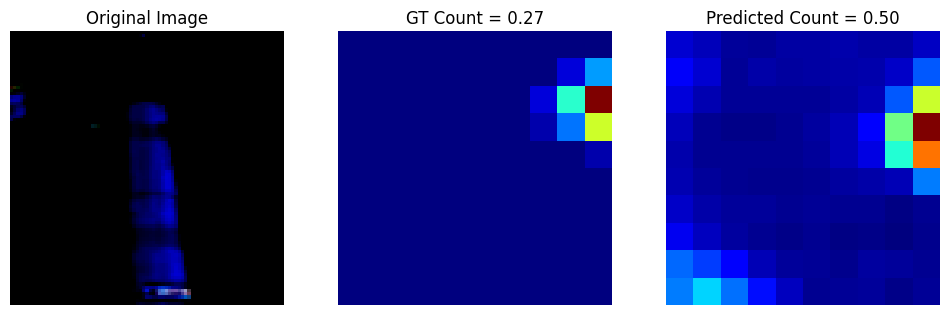

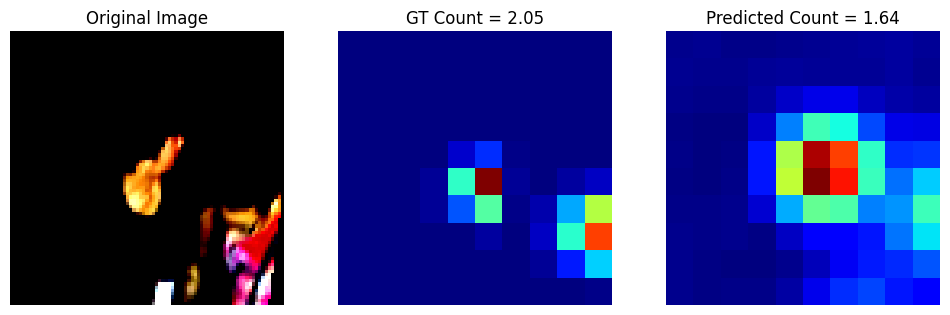

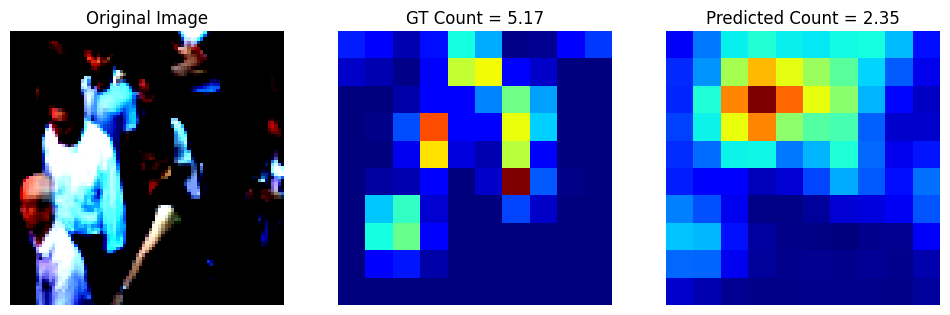

Epoch 0: Train Loss=31.9363, Val Loss=31.0485, MAE=2.18, RMSE=3.80

 Visualizing validation prediction sample...


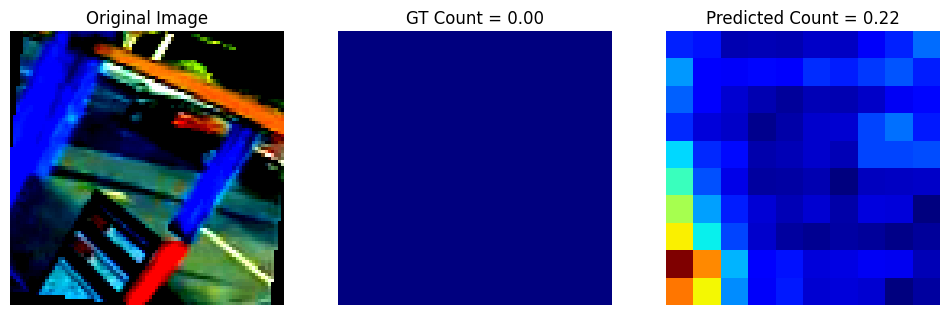

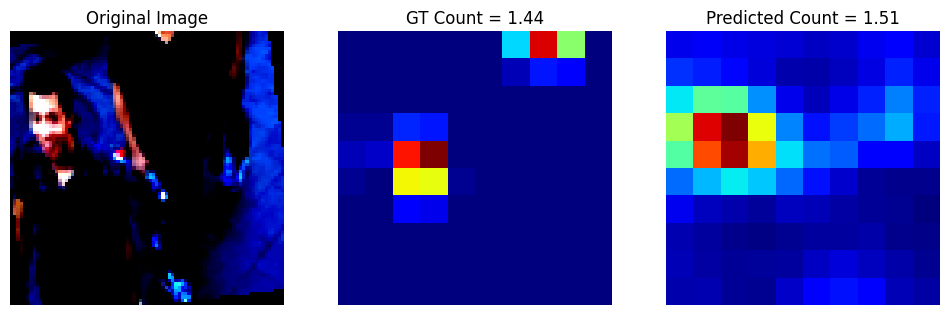

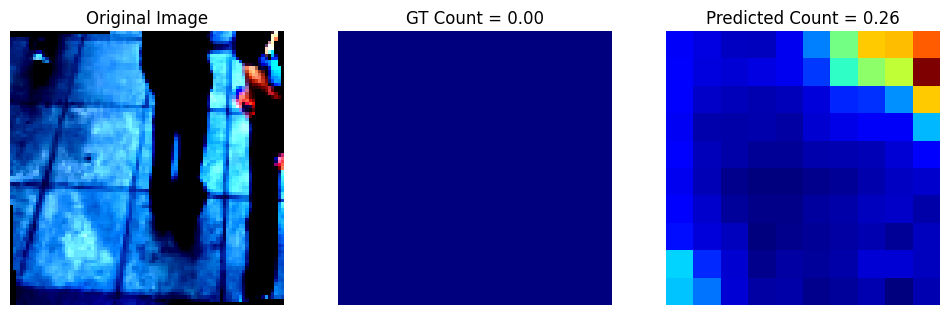

Best model updated at checkpoints/model_best.pth.tar
[Epoch 1] Step 64/428, Loss: 31.5838
[Epoch 1] Step 128/428, Loss: 24.4209
[Epoch 1] Step 192/428, Loss: 20.7363
[Epoch 1] Step 256/428, Loss: 37.3952
[Epoch 1] Step 320/428, Loss: 21.7704
[Epoch 1] Step 384/428, Loss: 21.8370
[Epoch 1] Step 428/428, Loss: 24.0907

Visualizing training prediction sample...


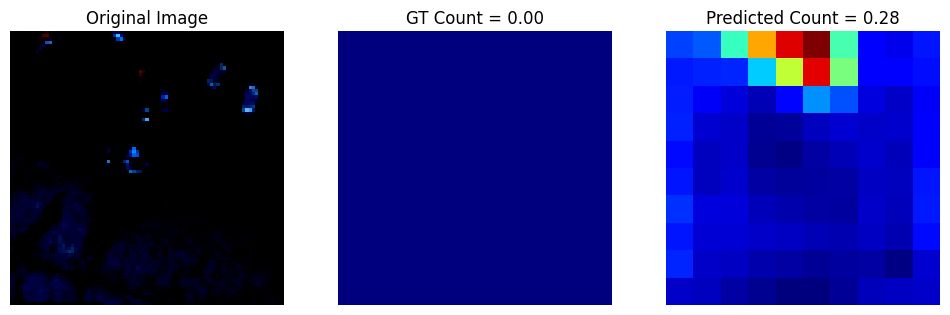

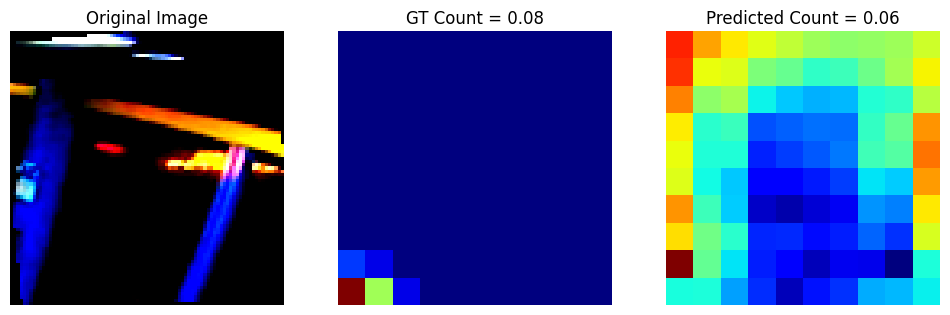

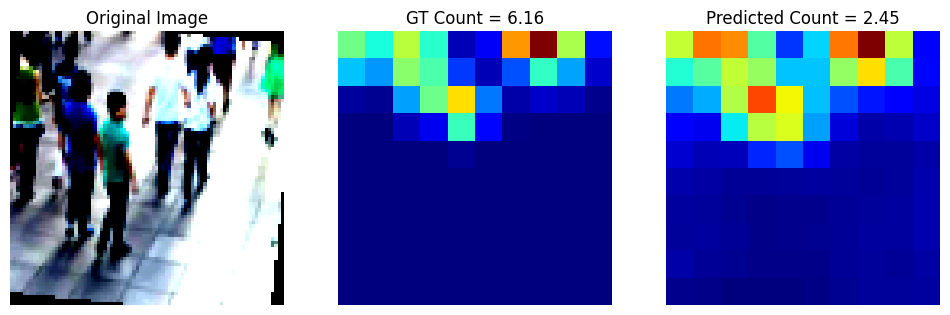

Epoch 1: Train Loss=27.2720, Val Loss=31.1949, MAE=2.29, RMSE=4.01

 Visualizing validation prediction sample...


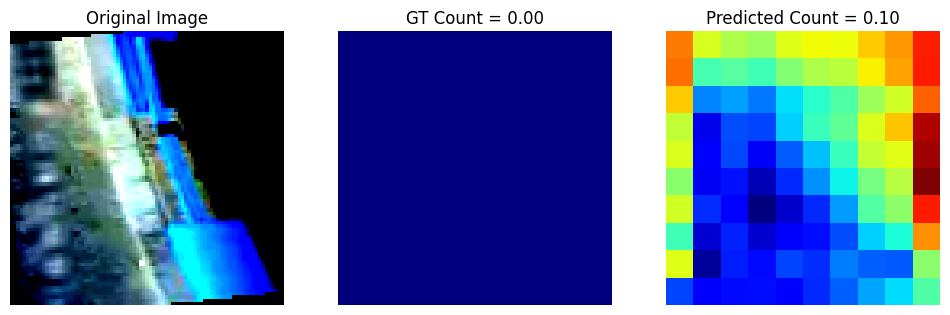

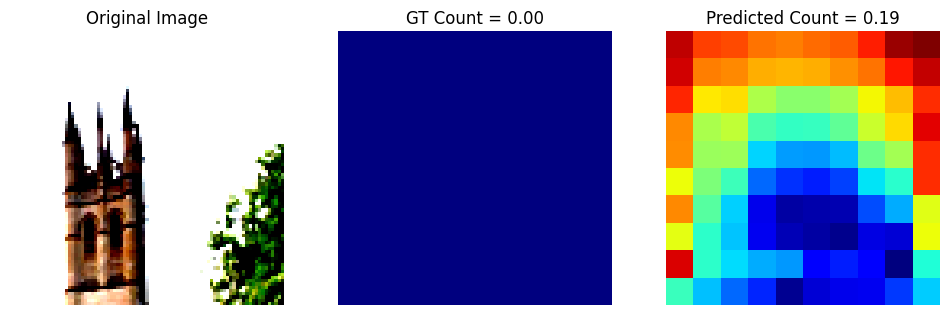

⏸ No improvement. Early stop counter: 1/25
[Epoch 2] Step 64/428, Loss: 22.6757
[Epoch 2] Step 128/428, Loss: 17.9019
[Epoch 2] Step 192/428, Loss: 45.1696
[Epoch 2] Step 256/428, Loss: 26.0625
[Epoch 2] Step 320/428, Loss: 22.1097
[Epoch 2] Step 384/428, Loss: 18.9857
[Epoch 2] Step 428/428, Loss: 15.0365

Visualizing training prediction sample...


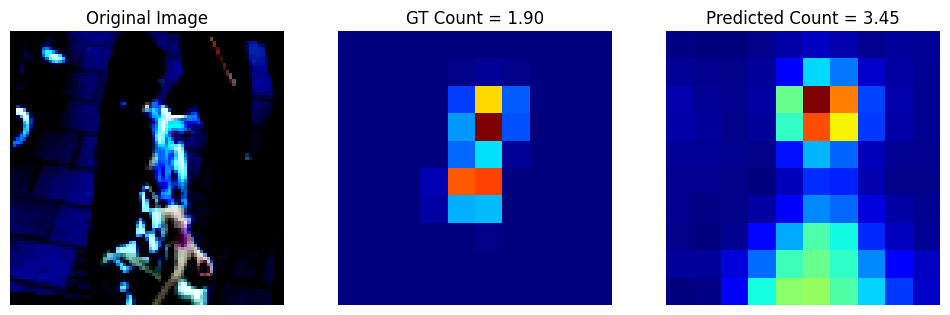

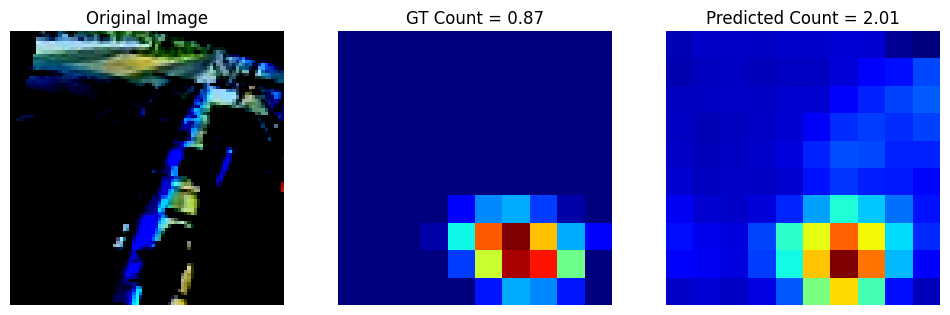

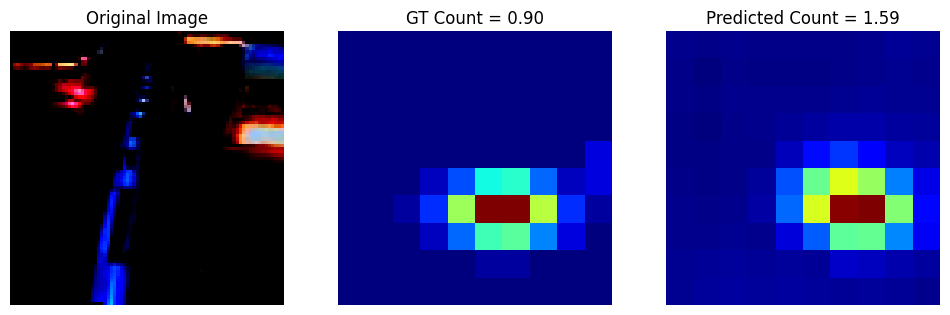

Epoch 2: Train Loss=25.7842, Val Loss=25.9632, MAE=1.56, RMSE=2.83

 Visualizing validation prediction sample...


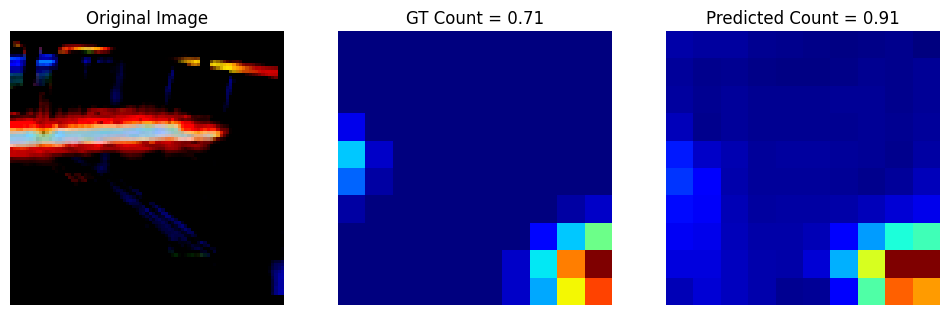

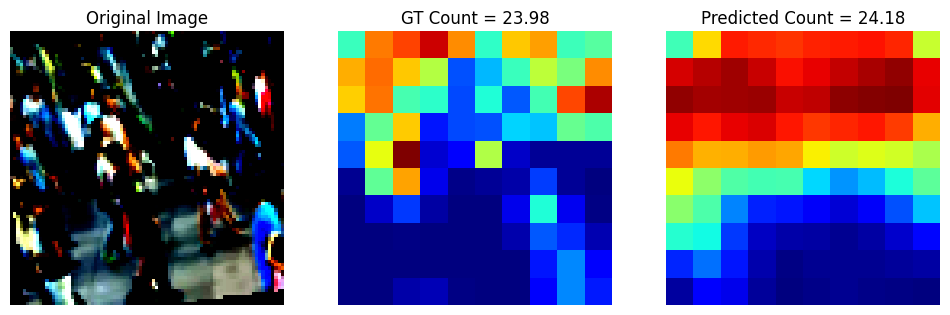

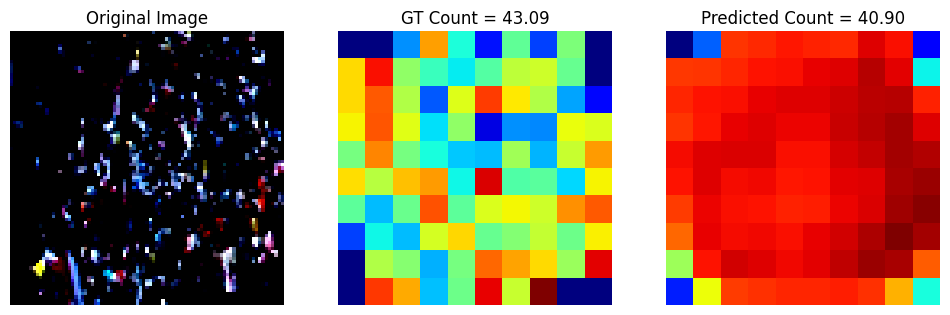

Best model updated at checkpoints/model_best.pth.tar
[Epoch 3] Step 64/428, Loss: 16.0944
[Epoch 3] Step 128/428, Loss: 22.2333
[Epoch 3] Step 192/428, Loss: 12.8793
[Epoch 3] Step 256/428, Loss: 33.6157
[Epoch 3] Step 320/428, Loss: 42.5471
[Epoch 3] Step 384/428, Loss: 34.2396
[Epoch 3] Step 428/428, Loss: 5.8969

Visualizing training prediction sample...


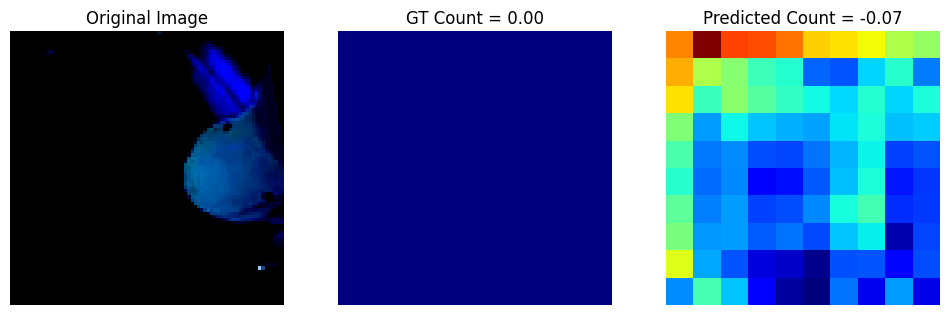

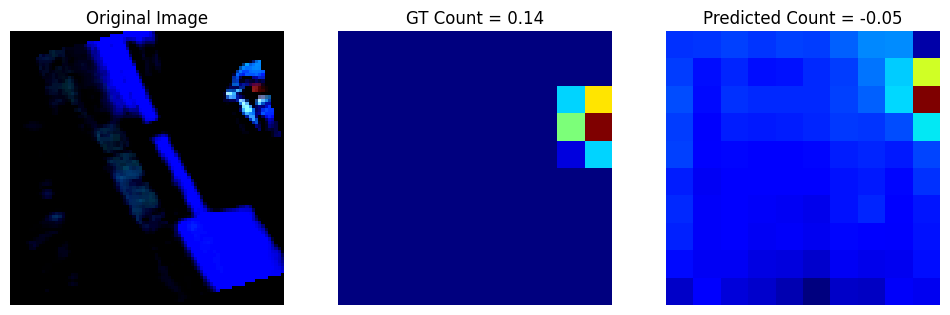

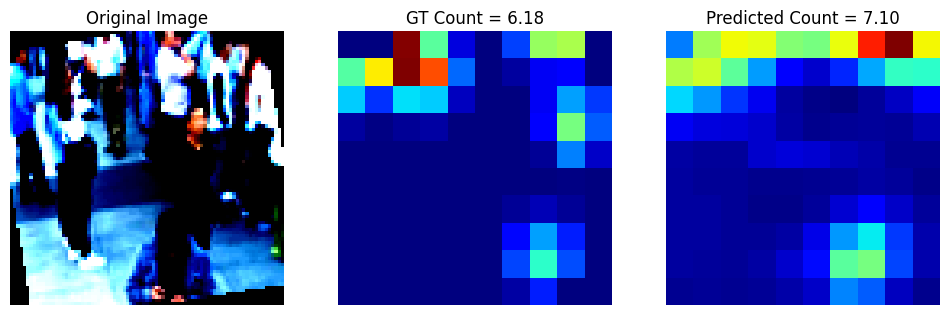

Epoch 3: Train Loss=24.3683, Val Loss=26.1042, MAE=1.60, RMSE=2.73

 Visualizing validation prediction sample...


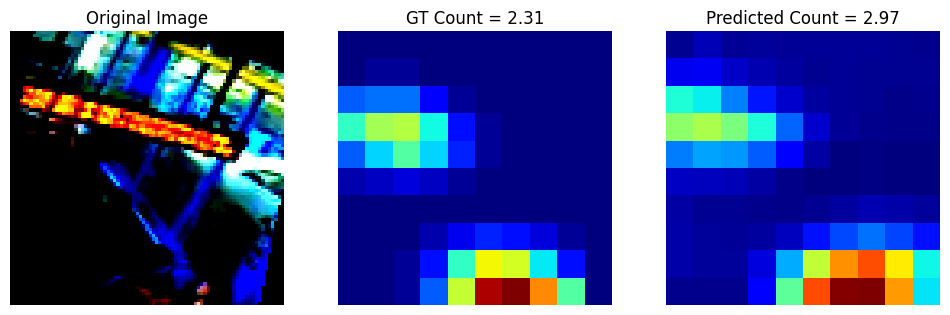

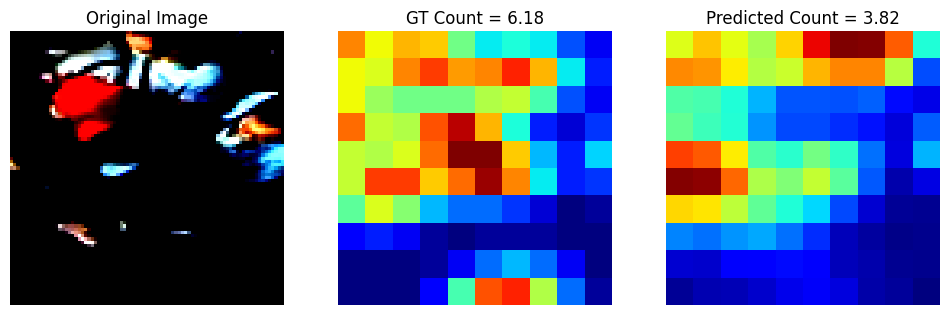

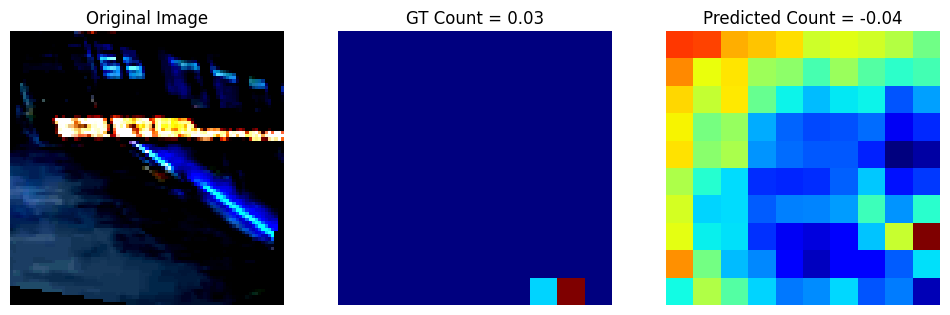

⏸ No improvement. Early stop counter: 1/25
[Epoch 4] Step 64/428, Loss: 25.7125
[Epoch 4] Step 128/428, Loss: 26.7259
[Epoch 4] Step 192/428, Loss: 5.1103
[Epoch 4] Step 256/428, Loss: 26.6079
[Epoch 4] Step 320/428, Loss: 36.9108
[Epoch 4] Step 384/428, Loss: 14.1474
[Epoch 4] Step 428/428, Loss: 9.9354

Visualizing training prediction sample...


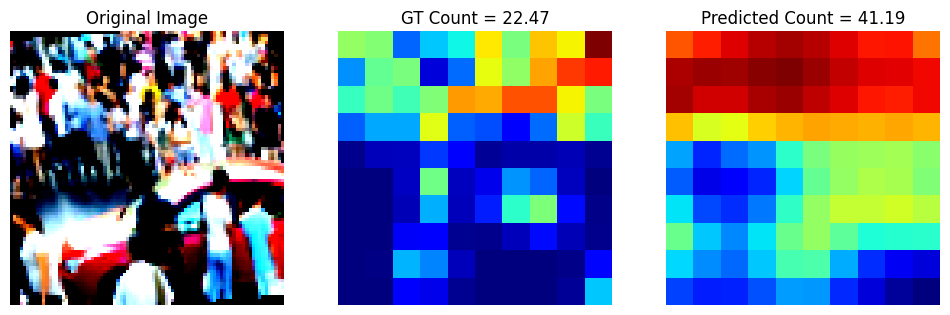

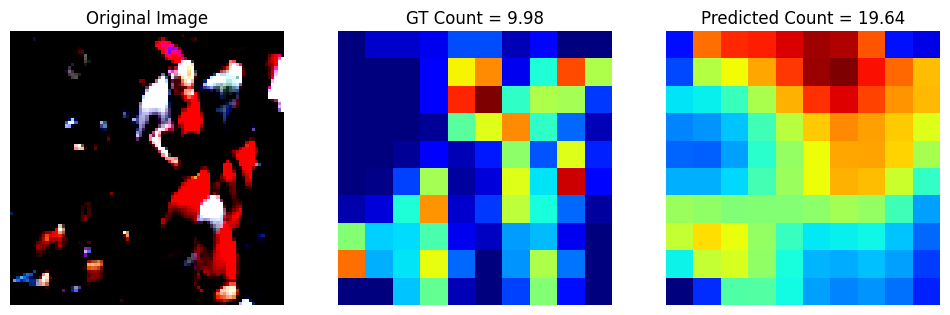

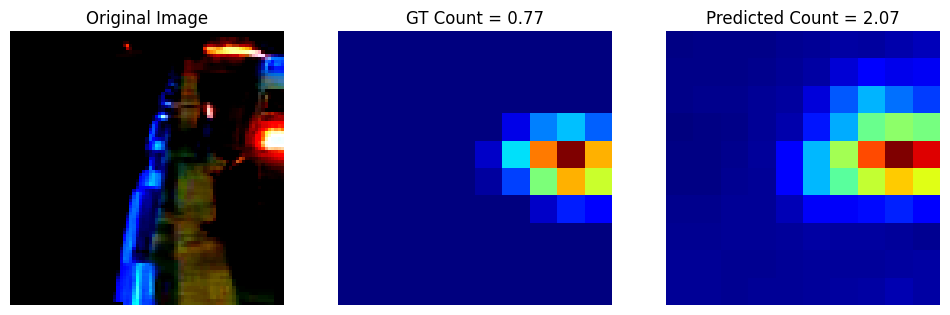

Epoch 4: Train Loss=23.9928, Val Loss=36.5761, MAE=3.34, RMSE=5.66

 Visualizing validation prediction sample...


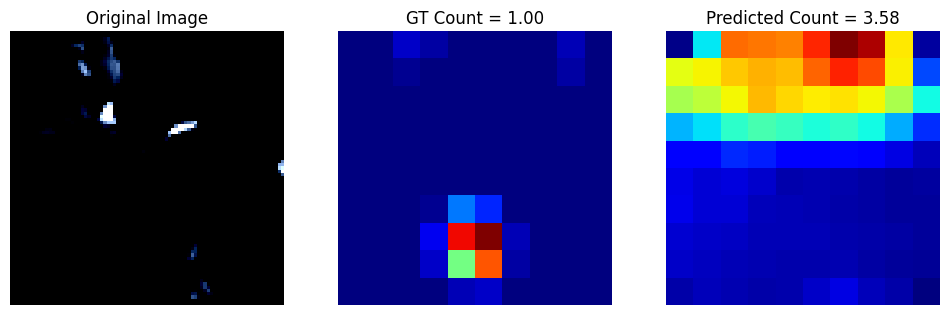

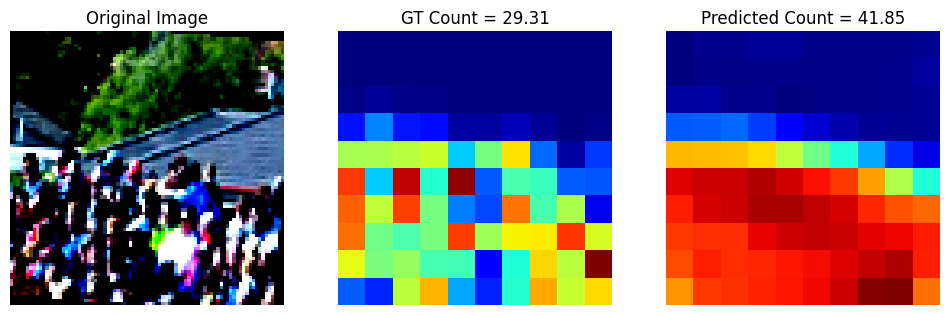

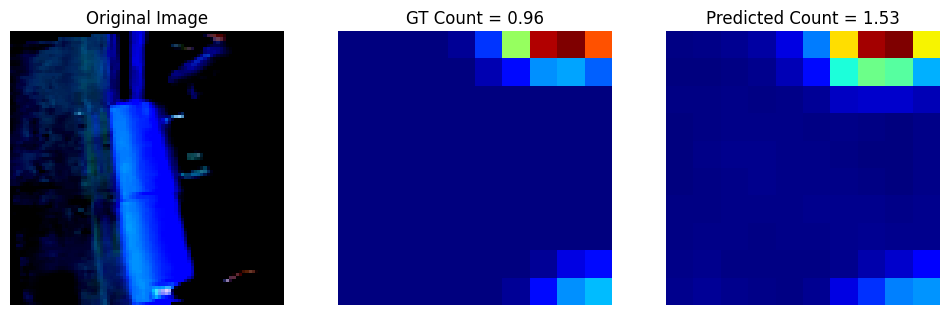

⏸ No improvement. Early stop counter: 2/25
[Epoch 5] Step 64/428, Loss: 24.1153
[Epoch 5] Step 128/428, Loss: 22.1167
[Epoch 5] Step 192/428, Loss: 21.9338
[Epoch 5] Step 256/428, Loss: 11.6969
[Epoch 5] Step 320/428, Loss: 17.3324
[Epoch 5] Step 384/428, Loss: 24.8519
[Epoch 5] Step 428/428, Loss: 7.0430

Visualizing training prediction sample...


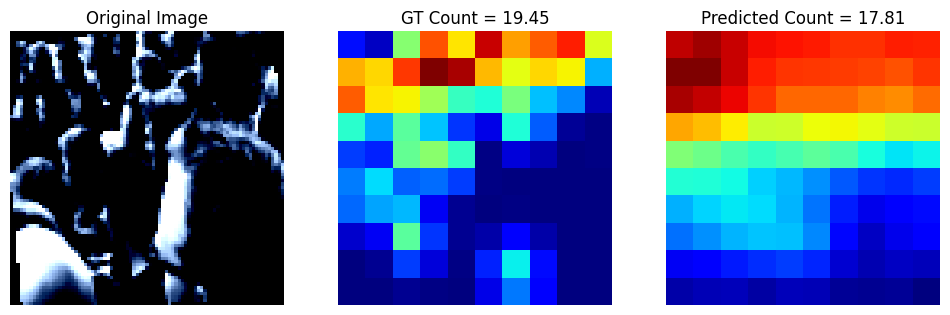

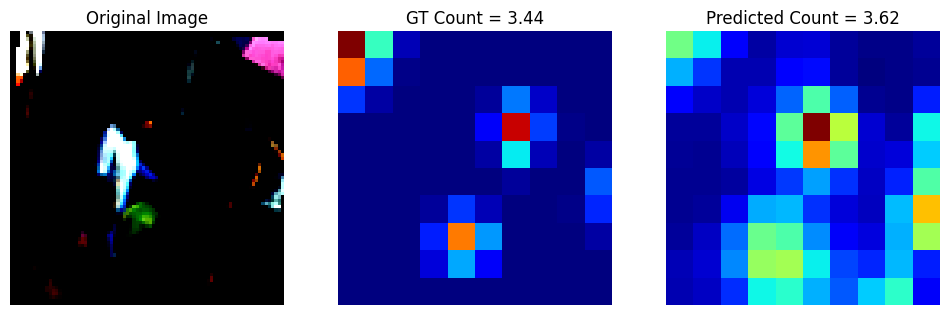

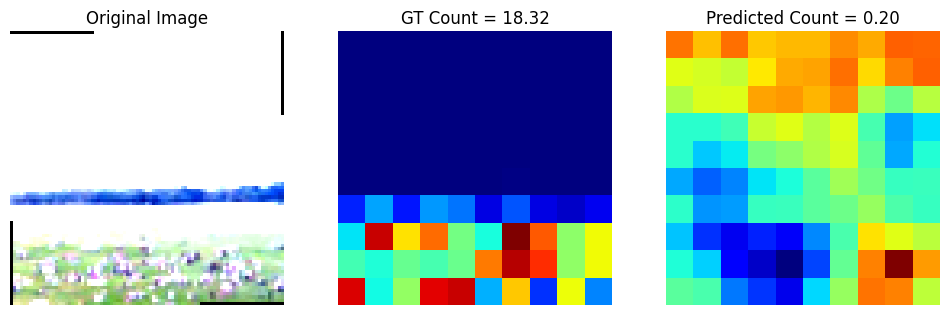

Epoch 5: Train Loss=22.8249, Val Loss=26.6142, MAE=1.76, RMSE=3.24

 Visualizing validation prediction sample...


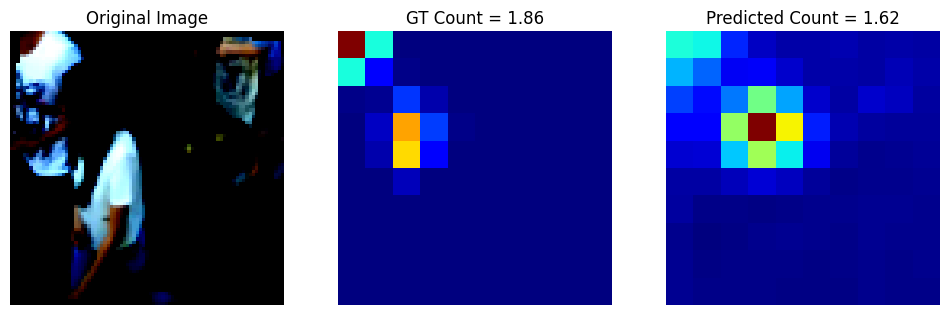

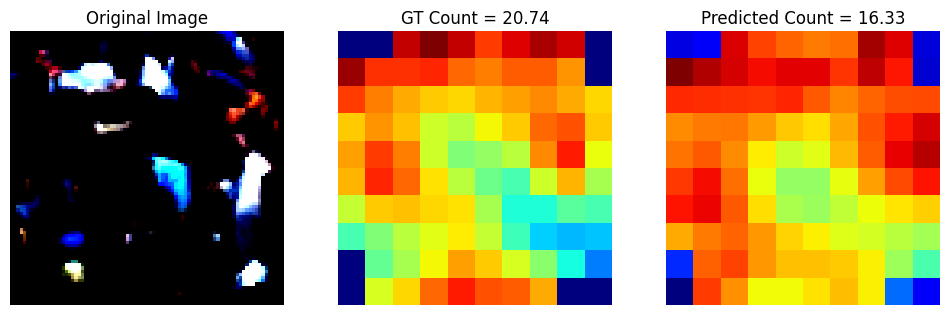

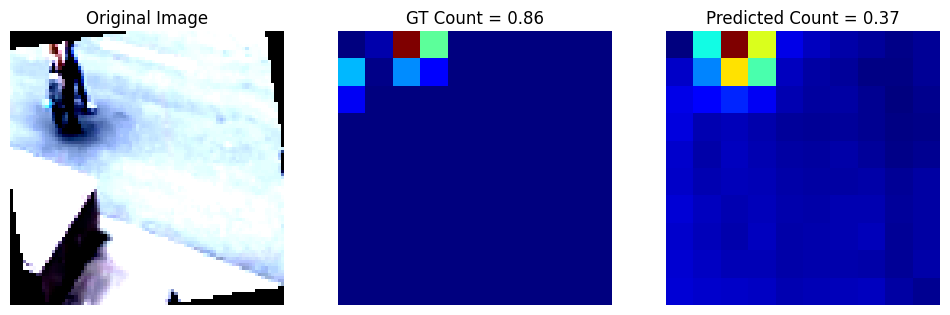

⏸ No improvement. Early stop counter: 3/25


In [8]:

# Hyperparameters

lr = 1e-4
decay = 5e-4
epochs = 6
print_freq = 64
patience = 25

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.manual_seed(int(time.time()))


# Loss, Optimizer, Scheduler
criterion = nn.MSELoss(reduction='sum').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, patience=10, factor=0.5, mode='min', verbose=True
)


# Train function 
def train_epoch(train_loader, model, criterion, optimizer, epoch, print_freq=16):
    model.train()
    running_loss = 0.0
    
    for i, (imgs, targets) in enumerate(train_loader):
        imgs = imgs.to(device).float()
        targets = targets.to(device).float()  # [B,1,H,W]

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i + 1) % print_freq == 0 or (i + 1) == len(train_loader):
            print(f"[Epoch {epoch}] Step {i+1}/{len(train_loader)}, Loss: {loss.item():.4f}")
    
    return running_loss / len(train_loader)


# Validation function 
def validate_epoch(val_loader, model, criterion):
    model.eval()
    losses = []
    mae_list = []
    rmse_list = []
    
    with torch.no_grad():
        for imgs, targets in val_loader:
            imgs = imgs.to(device).float()
            targets = targets.to(device).float()

            preds = model(imgs)
            loss = criterion(preds, targets)
            losses.append(loss.item())

            # convert density map → people count
            pred_counts = preds.sum(dim=(1, 2, 3)).cpu().numpy()
            true_counts = targets.sum(dim=(1, 2, 3)).cpu().numpy()

            mae_list.append(mean_absolute_error(true_counts, pred_counts))
            rmse_list.append(math.sqrt(mean_squared_error(true_counts, pred_counts)))
    
    return np.mean(losses), np.mean(mae_list), np.mean(rmse_list)


# Checkpoint function
def save_checkpoint(state, is_best, checkpoint_dir="checkpoints", filename="checkpoint.pth.tar"):
    os.makedirs(checkpoint_dir, exist_ok=True)
    filepath = os.path.join(checkpoint_dir, filename)
    torch.save(state, filepath)
    if is_best:
        best_path = os.path.join(checkpoint_dir, "model_best.pth.tar")
        shutil.copyfile(filepath, best_path)
        print(f"Best model updated at {best_path}")
    else:
        print(f"Checkpoint saved at {filepath}")


# Training Loop
best_loss = float('inf')
early_stop_counter = 0

for epoch in range(epochs):
    train_loss = train_epoch(train_loader, model, criterion, optimizer, epoch, print_freq)


    print("\nVisualizing training prediction sample...")
    visualize_prediction(model, val_loader, device, num_samples=3)
    
    val_loss, val_mae, val_rmse = validate_epoch(val_loader, model, criterion)

    print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
          f"MAE={val_mae:.2f}, RMSE={val_rmse:.2f}")

    print("\n Visualizing validation prediction sample...")
    visualize_prediction(model, val_loader, device, num_samples=3)

    # Scheduler step
    scheduler.step(val_loss)

    # Early stopping & checkpoint
    is_best = val_loss < best_loss
    if is_best:
        best_loss = val_loss
        save_checkpoint(
            {
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'best_loss': best_loss,
                'optimizer': optimizer.state_dict(),
            },
            is_best=True,
            filename=f'checkpoint_epoch_{epoch}.pth.tar'
        )
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        print(f"⏸ No improvement. Early stop counter: {early_stop_counter}/{patience}")
        if early_stop_counter >= patience:
            print("Early stopping triggered. Training stopped.")
            break



## Visualize Random Predictions (Validation Set)

### This helper function:
- Collects all images and ground-truth density maps from the validation loader.
- Randomly selects 'num_samples' validation images.
- Runs the model to predict their density maps.
- Shows side-by-side comparison:
      (1) Original Image
      (2) Ground Truth Density Map (with total count)
      (3) Predicted Density Map (with estimated count)

### What this visualization helps you understand:
- Whether the model learns dense vs sparse crowd areas correctly
- How close the predicted count is compared to the ground truth
- Provides qualitative insight — complementary to quantitative metrics (MAE)



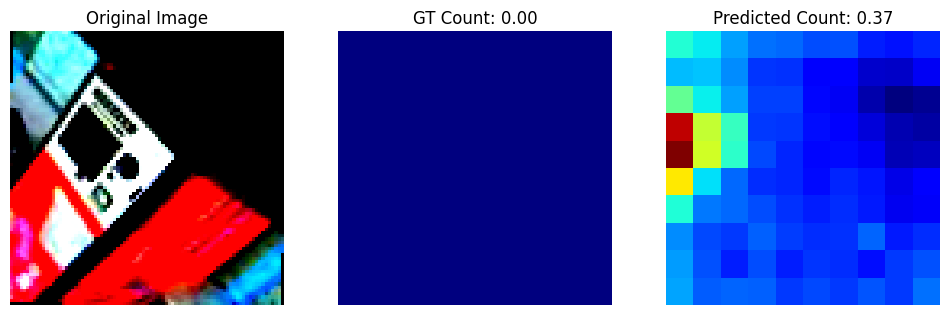

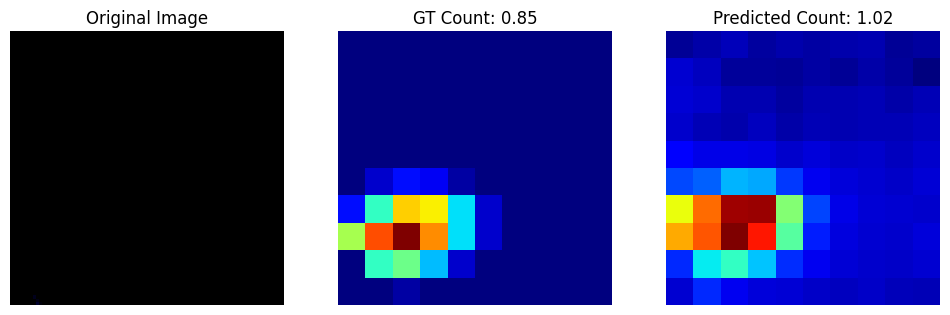

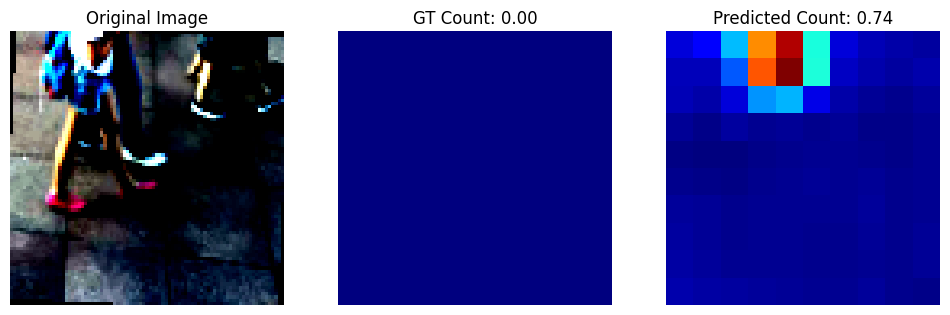

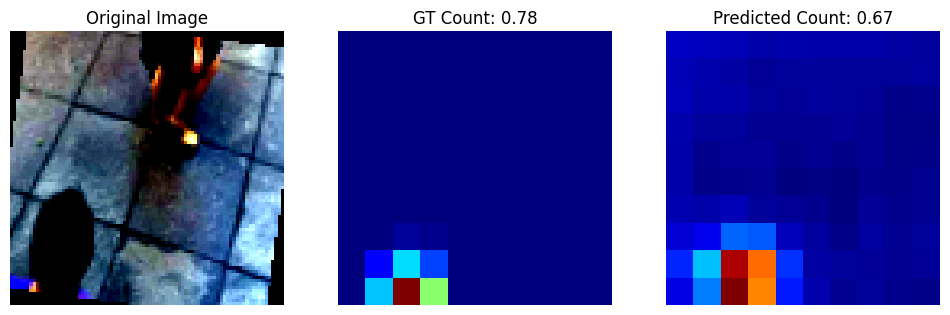

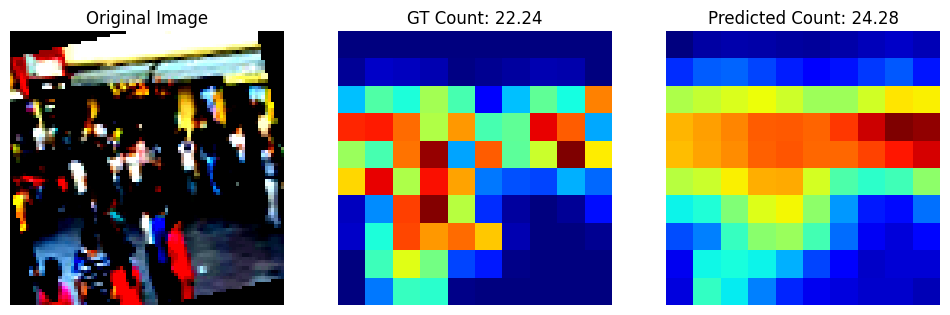

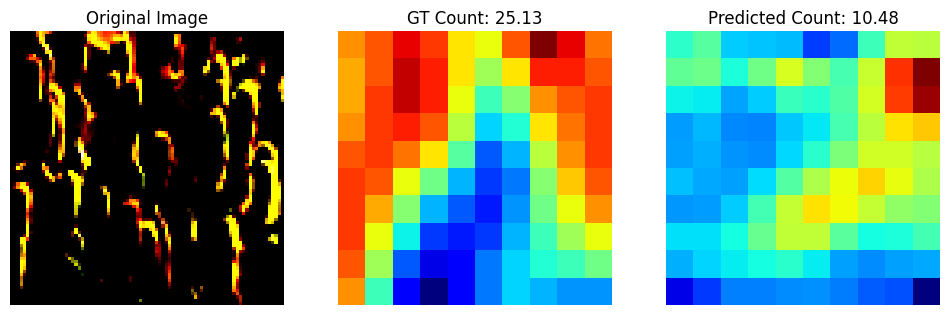

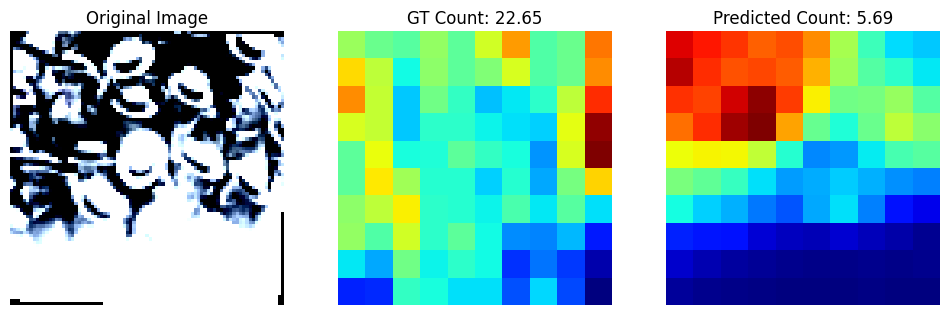

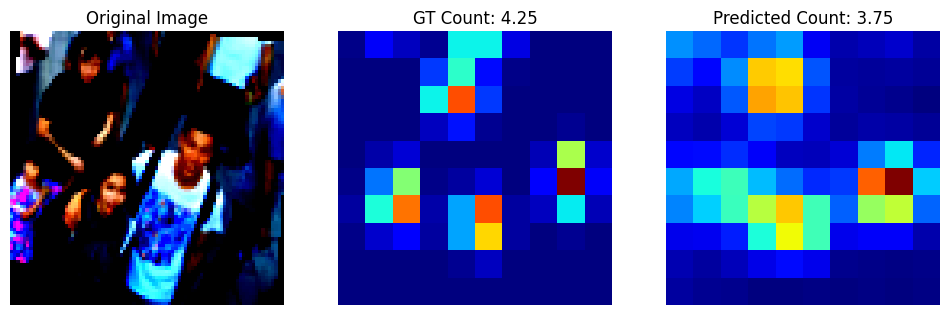

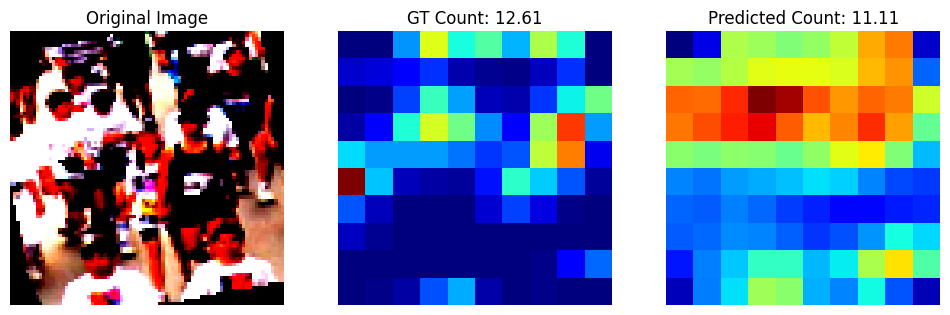

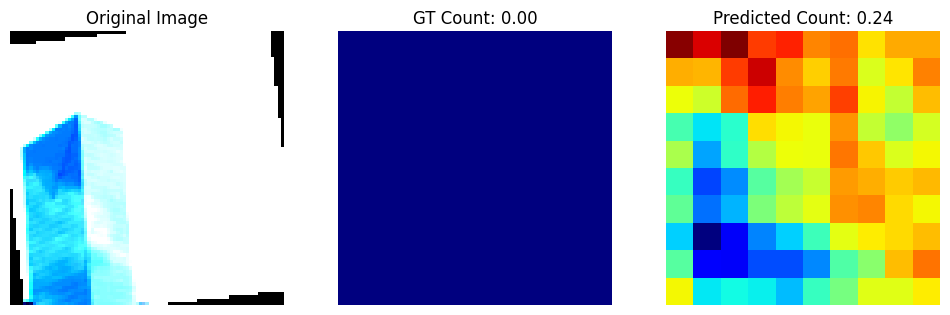

In [10]:


def visualize_random_predictions(model, val_loader, device, num_samples=5):
    """
    visualize predicted density map vs GT from random samples from val set
    """
    model.eval()
    

    all_imgs = []
    all_targets = []
    for imgs, targets in val_loader:
        all_imgs.append(imgs)
        all_targets.append(targets)
    all_imgs = torch.cat(all_imgs, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    
    # random index for val
    indices = random.sample(range(all_imgs.shape[0]), min(num_samples, all_imgs.shape[0]))
    
    for idx in indices:
        img = all_imgs[idx].unsqueeze(0).to(device)
        target = all_targets[idx].to(device)
        
        with torch.no_grad():
            pred = model(img)
        
        img_np = img[0].cpu().permute(1,2,0).numpy()
        gt_np = target[0].cpu().numpy()
        pred_np = pred[0,0].cpu().numpy()
        
        gt_count = gt_np.sum()
        pred_count = pred_np.sum()
        
        plt.figure(figsize=(12,4))
        
        plt.subplot(1,3,1)
        plt.imshow(img_np)
        plt.title("Original Image")
        plt.axis("off")
        
        plt.subplot(1,3,2)
        plt.imshow(gt_np, cmap="jet")
        plt.title(f"GT Count: {gt_count:.2f}")
        plt.axis("off")
        
        plt.subplot(1,3,3)
        plt.imshow(pred_np, cmap="jet")
        plt.title(f"Predicted Count: {pred_count:.2f}")
        plt.axis("off")
        
        plt.show()


device = "cuda" or "cpu"
visualize_random_predictions(model, val_loader, device, num_samples=10)



## Inference + Visualization (Single Image)

### This function:
1. Loads an image and its JSON annotation (head coordinates).
2. Generates the Ground Truth (GT) density map by scaling head points **from the original image size**, then resizing it to match CSRNet output resolution.
3. Splits the image into patches (NxN grid = num_patches).
4. Runs inference on each patch to avoid GPU memory issues.
5. Stitches all predicted patches into a full density map.
6. Visualizes:
      - Original Image (with patch grid overlay)
      - Original Image (clean)
      - Ground Truth Density Map
      - Predicted Density Map (CSRNetLite output)

### FYI:
- You might see a thin empty strip on the bottom/right — that’s just a visual effect from resizing and patch layout.
- It DOESNT EFFECT the model's output or density values at all.




In [51]:


def infer_and_visualize_fixed(model, image_path, label_path, device, resize_to=(256,256), num_patches=9):
    """
    Inference 1 gambar -> split patch -> predict -> combine -> output Predicted vs GT
    + overlay grid patching
    """
    model.eval()
    grid = int(np.sqrt(num_patches))
    assert grid * grid == num_patches, "num_patches harus perfect square"

    # Load original image for scaling 
    img_ori = Image.open(image_path).convert("RGB")
    W_ori, H_ori = img_ori.size

    # Resize image for model 
    img = img_ori.resize(resize_to)
    W, H = img.size

    # Load label JSON 
    with open(label_path, 'r') as f:
        data = json.load(f)
    points = data.get("points", [])

    #  Make GT density map 
    new_H, new_W = resize_to[1]//8, resize_to[0]//8  # CSRNet output scale
    density_gt = np.zeros((new_H, new_W), dtype=np.float32)

    for pt in points:
        x, y = pt['x'], pt['y']
        # scale from original size to density map 
        x_scaled = int(x * (new_W / W_ori))
        y_scaled = int(y * (new_H / H_ori))
        if 0 <= y_scaled < new_H and 0 <= x_scaled < new_W:
            density_gt[y_scaled, x_scaled] = 1.0

    # --- Split patch & predict ---
    patch_w = resize_to[0] // grid
    patch_h = resize_to[1] // grid
    den_patch_w = new_W // grid
    den_patch_h = new_H // grid

    pred_density_full = np.zeros((new_H, new_W), dtype=np.float32)

    for gy in range(grid):
        for gx in range(grid):
            x1, y1 = gx*patch_w, gy*patch_h
            x2, y2 = x1+patch_w, y1+patch_h
            img_patch = img.crop((x1, y1, x2, y2))
            img_tensor = TF.to_tensor(img_patch).unsqueeze(0).to(device)
            img_tensor = TF.normalize(img_tensor,
                                      mean=[0.485,0.456,0.406],
                                      std=[0.229,0.224,0.225])
            with torch.no_grad():
                pred_patch = model(img_tensor).squeeze().cpu().numpy()
            pred_density_full[gy*den_patch_h:(gy+1)*den_patch_h,
                              gx*den_patch_w:(gx+1)*den_patch_w] = pred_patch


    img_with_grid = img.copy()
    draw = ImageDraw.Draw(img_with_grid)
    for i in range(1, grid):
        draw.line([(i*patch_w,0),(i*patch_w,H)], fill=(255,0,0), width=2)
        draw.line([(0,i*patch_h),(W,i*patch_h)], fill=(255,0,0), width=2)

    plt.figure(figsize=(15,5))

    plt.subplot(1,4,1)
    plt.imshow(img_with_grid)
    plt.title("Original Image + Grid")
    plt.axis("off")

    plt.subplot(1,4,2)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1,4,3)
    plt.imshow(density_gt, cmap="jet")
    plt.title(f"GT Count = {density_gt.sum():.2f}")
    plt.axis("off")

    plt.subplot(1,4,4)
    plt.imshow(pred_density_full, cmap="jet")
    plt.title(f"Predicted Count = {pred_density_full.sum():.2f}")
    plt.axis("off")

    plt.show()

    return pred_density_full, density_gt



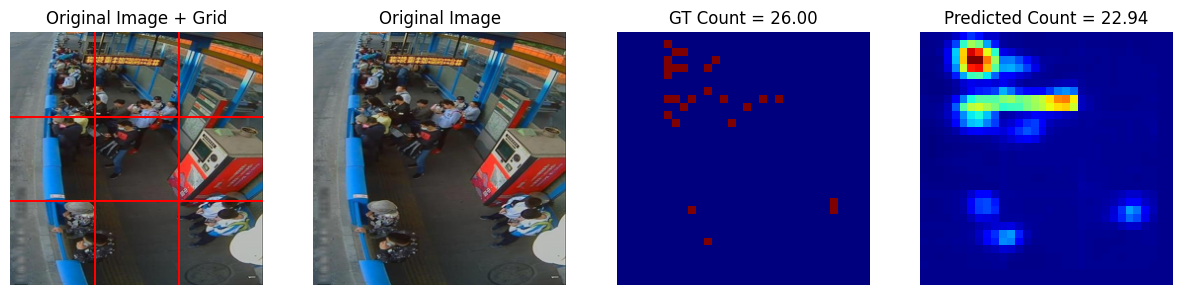

In [55]:
test_image = "/kaggle/working/split_data/test/images/1024.jpg"
test_label = "/kaggle/working/split_data/test/labels/1024.json"

density_pred, density_gt = infer_and_visualize_fixed(
    model, test_image, test_label, device, resize_to=(256,256), num_patches=9
)


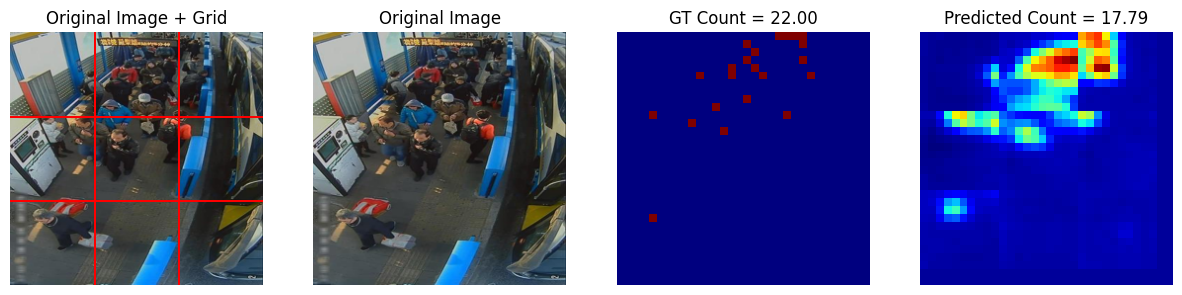

In [52]:
test_image = "/kaggle/working/split_data/test/images/1019.jpg"
test_label = "/kaggle/working/split_data/test/labels/1019.json"

density_pred, density_gt = infer_and_visualize_fixed(
    model, test_image, test_label, device, resize_to=(256,256), num_patches=9
)


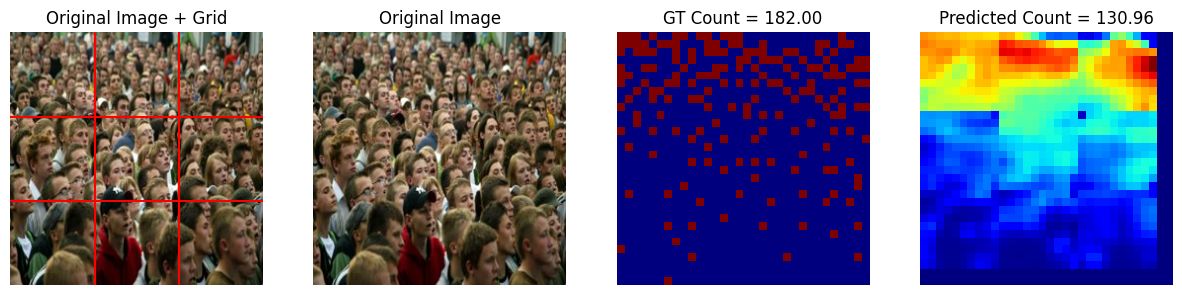

In [54]:
test_image = "/kaggle/working/split_data/test/images/1055.jpg"
test_label = "/kaggle/working/split_data/test/labels/1055.json"

density_pred, density_gt = infer_and_visualize_fixed(
    model, test_image, test_label, device, resize_to=(256,256), num_patches=9
)



## Evaluate Model on Full Test Set (Patch-based Inference)

### This function:
1. Loads each test image and its JSON annotation (head coordinates).
2. Resizes the image and generates the Ground Truth (GT) density map.
3. Splits the image into patches (N patches = num_patches).
4. Runs inference per patch to avoid GPU memory issues on large images.
5. Stitches all predicted patches back into one full density map.
6. Counts heads by summing density values and computes MAE per image.

### Output:
- Prints total test images evaluated
- Returns Mean Absolute Error (MAE) on the whole test dataset



In [85]:
def evaluate_test_set(model, test_img_dir, test_label_dir, device, resize_to=(256,256), num_patches=9):

    model.eval()
    mae_list = []

    test_images = sorted([f for f in os.listdir(test_img_dir) if f.lower().endswith((".jpg",".png"))])
    grid = int(np.sqrt(num_patches))
    assert grid * grid == num_patches

    for img_file in test_images:
        img_path = os.path.join(test_img_dir, img_file)
        label_path = os.path.join(test_label_dir, img_file.rsplit('.',1)[0]+".json")

        # Load & resize image
        img = Image.open(img_path).convert("RGB")
        img = img.resize(resize_to)
        W, H = img.size

        # Load JSON
        with open(label_path, 'r') as f:
            data = json.load(f)
        points = data.get("points", [])

        # GT density map 
        new_H, new_W = resize_to[1]//8, resize_to[0]//8
        density_gt = np.zeros((new_H, new_W), dtype=np.float32)
        for pt in points:
            x = pt['x']
            y = pt['y']
            x_scaled = int(x * (resize_to[0] / W) / 8)
            y_scaled = int(y * (resize_to[1] / H) / 8)
            if 0 <= y_scaled < new_H and 0 <= x_scaled < new_W:
                density_gt[y_scaled, x_scaled] = 1.0

        # split patch & prediksi 
        patch_w = resize_to[0] // grid
        patch_h = resize_to[1] // grid
        den_patch_w = new_W // grid
        den_patch_h = new_H // grid
        pred_density_full = np.zeros((new_H, new_W), dtype=np.float32)

        for gy in range(grid):
            for gx in range(grid):
                x1, y1 = gx*patch_w, gy*patch_h
                x2, y2 = x1+patch_w, y1+patch_h
                img_patch = img.crop((x1, y1, x2, y2))
                img_tensor = TF.to_tensor(img_patch).unsqueeze(0).to(device)
                img_tensor = TF.normalize(img_tensor,
                                          mean=[0.485,0.456,0.406],
                                          std=[0.229,0.224,0.225])
                with torch.no_grad():
                    pred_patch = model(img_tensor).squeeze().cpu().numpy()
                pred_density_full[gy*den_patch_h:(gy+1)*den_patch_h,
                                  gx*den_patch_w:(gx+1)*den_patch_w] = pred_patch

        # calculate MAE count per image
        gt_count = density_gt.sum()
        pred_count = pred_density_full.sum()
        mae = abs(gt_count - pred_count)
        mae_list.append(mae)

    mean_mae = np.mean(mae_list)
    print(f"Test Set Evaluated: {len(test_images)} images")
    print(f"Mean Absolute Error (MAE) on Test Set = {mean_mae:.2f}")
    return mean_mae


In [86]:
test_img_dir = "/kaggle/working/split_data/test/images"
test_label_dir = "/kaggle/working/split_data/test/labels"

mean_mae = evaluate_test_set(model, test_img_dir, test_label_dir, device,
                             resize_to=(256,256), num_patches=9)


Test Set Evaluated: 190 images
Mean Absolute Error (MAE) on Test Set = 33.47
